## 0 import

In [ ]:
# Installations
!pip install kagglehub seaborn matplotlib pandas numpy scikit-learn nltk gensim pyLDAvis rank_bm25 torch transformers sentence-transformers tqdm faiss-cpu openai

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 43.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 47.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 74.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 59.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.9 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 95.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 127.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.9 MB/s eta 

In [7]:
import os
import shutil
import kagglehub
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('wordnet')
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import LdaMulticore
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(42)
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.decomposition import NMF
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from rank_bm25 import BM25Okapi
from sklearn.metrics import ndcg_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util


[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...


In [8]:
# Download the datasets
cache_path = kagglehub.dataset_download("gesp19/nlp-final-project")
target_dir = "data"

# Remove existing target directory if it exists
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

shutil.copytree(cache_path, target_dir)

# Flatten nested "data/data" if exists
inner_data_path = os.path.join(target_dir, "data")
if os.path.exists(inner_data_path) and os.path.isdir(inner_data_path):
    for item in os.listdir(inner_data_path):
        src_path = os.path.join(inner_data_path, item)
        dst_path = os.path.join(target_dir, item)
        if os.path.isdir(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dst_path)
    shutil.rmtree(inner_data_path)

100%|██████████| 2.13M/2.13M [00:00<00:00, 3.82MB/s]

Extracting files...


In [9]:
# Set working directory
os.chdir("data")

# Load the ACORD corpus 
corpus_path = "corpus.jsonl"
acord_corpus = []
with open(corpus_path, "r", encoding="utf-8") as f:
    for line in f:
        acord_corpus.append(json.loads(line))

# Load the queries in json format
queries_path = "queries.jsonl"
acord_queries = []
with open(queries_path, "r", encoding="utf-8") as f:
    for line in f:
        acord_queries.append(json.loads(line))

print(f"Loaded {len(acord_corpus)} corpus entries and {len(acord_queries)} queries.")

Loaded 3931 corpus entries and 114 queries.


In [10]:
# example and keys
print(f"""Corpus keys:{acord_corpus[0].keys()}
      sample:{acord_corpus[0]},\n
      Query keys: {acord_queries[0].keys()}
      sample: {acord_queries[0]}""")

Corpus keys:dict_keys(['_id', 'text'])
      sample:{'_id': 'a5a68dbd19', 'text': "In no event may either party sell, disclose, transfer, rent, or license Payment-Eligible User Data to the other party's Named Competitors as listed in EXHIBIT E. Furthermore, Excite@Home may not sell, disclose, transfer, rent, or license Shopping Category Data or Superset Data to Data Restricted Named Companies as specified in EXHIBIT I. Not more than once per quarter, Application Provider may update the list of Application Provider Data Restricted Named Companies shown in EXHIBIT I, so long as such list shall not exceed twenty-five (25) companies."},

      Query keys: dict_keys(['_id', 'text', 'metadata'])
      sample: {'_id': 'New York Governing Law', 'text': 'New York Governing Law', 'metadata': {'category': 'Governing Law', 'parent_query_id': '', 'type': 'cuad1', 'split': 'train'}}


## 1 Raw EDA

#### **Keywork matching**
for each query count the number of overlapping words in the corpus, the higher the better

In [11]:
def tokenize(text):
    return set(re.findall(r'\w+', text.lower()))

corpus = [entry['text'] for entry in acord_corpus]
queries = [q['text'] for q in acord_queries]

for i, query in enumerate(queries[:3]):  # First 5 for demo
    query_tokens = tokenize(query)
    best_score = 0
    best_idx = 0
    for idx, doc in enumerate(corpus):  
        doc_tokens = tokenize(doc)
        score = len(query_tokens & doc_tokens)
        if score > best_score:
            best_score = score
            best_idx = idx
    print(f"Query: {query}")
    print(f"Best matching corpus (keyword overlap={best_score}): {corpus[best_idx][:100]}...\n")

Query: New York Governing Law
Best matching corpus (keyword overlap=3): This Agreement, the rights and obligations of the parties hereto, and any claims or disputes thereto...

Query: England Governing Law
Best matching corpus (keyword overlap=2): This Agreement shall be deemed to have been made and executed in the State of Missouri and any dispu...

Query: Clause with multiple governing laws
Best matching corpus (keyword overlap=3): Upon the request of the Trust or its designee, Administrator shall provide copies of all the histori...



#### **TF-IDF**
represent both corpus and queries as vectors, compute cosine similarities and select the document with the highest score

In [12]:
# Fit TF-IDF
vectorizer = TfidfVectorizer().fit(corpus)
corpus_vectors = vectorizer.transform(corpus)

# For each query, find the most similar dialogue
for i, query in enumerate(queries[:5]):  # Just first 5 for demo
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, corpus_vectors)
    best_idx = sims.argmax()
    print(f"Query: {query}")
    print(f"Best matching corpus (TF-IDF score={sims[0, best_idx]:.3f}): {corpus[best_idx][:100]}...\n")


Query: New York Governing Law
Best matching corpus (TF-IDF score=0.466): This Agreement shall be governed by, and construed in accordance with the law of the State of New Yo...

Query: England Governing Law
Best matching corpus (TF-IDF score=0.477): This Agreement shall be governed by the laws of England and Wales, and all actions brought hereunder...

Query: Clause with multiple governing laws
Best matching corpus (TF-IDF score=0.276): THE INTERPRETATION AND PERFORMANCE OF THIS CONTRACT SHALL BE IN ACCORDANCE WITH AND CONTROLLED BY TH...

Query: Governing Law excluding UCC or other similar regulatory frameworks
Best matching corpus (TF-IDF score=0.244): The terms of the Governing Law and Dispute Resolution provisions of the Distribution Agreement will ...

Query: Most Favored Nation Clause
Best matching corpus (TF-IDF score=0.168): 9. LIMITATION OF LIABILITY
9.1 Nothing in this Agreement shall exclude or limit either party's liabi...



In [13]:
# 1. Tokenize documents
tokenized_corpus = [simple_preprocess(doc) for doc in corpus]

# 2. Create dictionary
dictionary = Dictionary(tokenized_corpus)

# 3. Convert to BoW
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_corpus]

#### **LDA** BoW

In [14]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=9, 
                                       id2word=dictionary, passes=2, 
                                       workers=6, eval_every=1)

# On Ucloud it gives a warning because LdaMulticore uses Python's multiprocessing with the fork start method.
# On recent Python versions, forking a multi-threaded process (like Jupyter) may cause deadlocks or unexpected behavior.
# However, the code runs fine

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: D

In [15]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.067*"the" + 0.040*"of" + 0.037*"and" + 0.035*"to" + 0.020*"or" + 0.015*"in" + 0.013*"agreement" + 0.013*"party" + 0.012*"any" + 0.011*"this"
Topic: 1 
Words: 0.073*"the" + 0.047*"and" + 0.046*"of" + 0.031*"or" + 0.031*"to" + 0.026*"in" + 0.021*"any" + 0.015*"for" + 0.011*"shall" + 0.010*"this"
Topic: 2 
Words: 0.088*"the" + 0.040*"to" + 0.034*"or" + 0.033*"of" + 0.030*"and" + 0.019*"in" + 0.014*"any" + 0.013*"by" + 0.012*"shall" + 0.011*"agreement"
Topic: 3 
Words: 0.059*"or" + 0.043*"the" + 0.041*"of" + 0.034*"any" + 0.024*"to" + 0.022*"in" + 0.021*"and" + 0.016*"this" + 0.015*"by" + 0.012*"shall"
Topic: 4 
Words: 0.053*"or" + 0.050*"of" + 0.049*"the" + 0.031*"and" + 0.029*"to" + 0.028*"any" + 0.020*"in" + 0.019*"party" + 0.014*"such" + 0.013*"by"
Topic: 5 
Words: 0.052*"and" + 0.044*"of" + 0.043*"the" + 0.038*"to" + 0.023*"or" + 0.018*"in" + 0.014*"any" + 0.012*"this" + 0.012*"shall" + 0.012*"such"
Topic: 6 
Words: 0.040*"the" + 0.037*"of" + 0.034*"to" + 0.030*"and

The first exploratory analysis ends here. The LDA can't correctly cathegorize the topics as stopwords are still present. In addition, the queries json file doesn't include lawyers ratings, which are only present in the queries tsv file.
In the next section we will import the lawyers scores, preprocess the data and continue the analysis

## 2 Minimal preprocessing

#### Import the tsv queries file with layers grades


In [16]:
# Read the TSV file
rated_queries_df1 = pd.read_csv('train.tsv', sep='\t')
rated_queries_df2 = pd.read_csv('test.tsv', sep='\t')
rated_queries_df3 = pd.read_csv('valid.tsv', sep='\t')

rated_queries_df = pd.concat([rated_queries_df1, rated_queries_df2, rated_queries_df3], ignore_index=True)

# Access columns using valid variable names
query_id = rated_queries_df['query-id']
corpus_id = rated_queries_df['corpus-id']
score = rated_queries_df['score']

rated_queries_df

,query-id,corpus-id,score
0,"""as is"" clause with carveouts",e279fd792f,3
1,"""as is"" clause with carveouts",4f06e1c658,3
2,"""as is"" clause with carveouts",adec05476d,1
3,"""as is"" clause with carveouts",494c10db01,3
4,"""as is"" clause with carveouts",e282637c4e,3
...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0


#### Merge the corpus and the queries in a single df

In [17]:
# Convert acord_corpus (list of dicts) to df
acord_corpus_df = pd.DataFrame(acord_corpus)

# Merge on corpus-id from rated_queries_df and id from acord_corpus_df
merged_df = rated_queries_df.merge(acord_corpus_df, left_on='corpus-id', right_on='_id', how='left')
merged_df = merged_df.drop(columns=['_id']) #drop _id column as it is a duplicate of corpus-id

# Check
merged_df
# nonzero_count = (merged_df['score'] > 0).sum()
# total_count = len(merged_df)
# print(f"Number of non-zero lawyer's score rows: {nonzero_count}")
# print(f"Total number of rows: {total_count}")

,query-id,corpus-id,score,text
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...
...,...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0,save that nothing in this paragraph 13.2 shall...
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0,"the Customer is granted a non-exclusive, non-t..."
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0,the Parties may at any time assign or transfer...
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0,uch fee shall be paid after only the first to ...


#### Preprocess the corpus and the queries

In [18]:
stemmer = SnowballStemmer('english')
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

In [19]:
# Apply the preprocess function to all documents in the merged df
processed_corpus = [preprocess(text) for text in merged_df['text']]

# Print a sample 
sample_idx = 1234
print("Original document:\n", merged_df['text'].iloc[sample_idx])
print("\nTokenized, lemmatized, stopwords-removed document:\n", processed_corpus[sample_idx])

Original document:
 Upon the termination of this Agreement, Operator shall cooperate in the transition of operations to Owner or a successor operator and upon Owner's request, will promptly deliver all books and records and other property (including, without limitation, intellectual property) of Owner to Owner or the successor operator, as applicable.

Tokenized, lemmatized, stopwords-removed document:
 ['termination', 'agreement', 'operator', 'shall', 'cooperate', 'transition', 'operations', 'owner', 'successor', 'operator', 'owner', 'request', 'promptly', 'deliver', 'book', 'record', 'property', 'include', 'limitation', 'intellectual', 'property', 'owner', 'owner', 'successor', 'operator', 'applicable']


In [20]:
# Preprocess the queries in the merged DataFrame
processed_queries = [preprocess(q) for q in merged_df['query-id']]

#### Keyword matching

In [21]:
# Print 5 unique queries and their best matches
seen = set()
printed = 0
for i, query_tokens in enumerate(processed_queries):
    query_str = ' '.join(query_tokens)
    if query_str in seen:
        continue
    seen.add(query_str)
    best_score = 0
    best_idx = 0
    for idx, doc_tokens in enumerate(processed_corpus):
        score = len(set(query_tokens) & set(doc_tokens))
        if score > best_score:
            best_score = score
            best_idx = idx
    print(f"Query: {query_str}")
    print(f"Best matching corpus (keyword overlap={best_score}): {' '.join(processed_corpus[best_idx][:10])}...\n")
    printed += 1
    if printed == 5:
        break

Query: clause carveouts
Best matching corpus (keyword overlap=1): agreement terminate prior conclusion term give write notice termination omit...

Query: liability carveouts
Best matching corpus (keyword overlap=1): disclaimer warranties warrant validity patent practice patent manufacture sale import...

Query: clause require notice terminate auto renew
Best matching corpus (keyword overlap=4): event ivillage fail deliver advertise impressions promotion period shall option...

Query: covenant
Best matching corpus (keyword overlap=1): aimmune covenant research develop include develop antibody include develop modification...

Query: exclusivity bind time territory
Best matching corpus (keyword overlap=4): hydraspin grant distributor exclusive transferable royalty free right license hydraspin...



#### TF-IDF

In [22]:
# Join tokens for TF-IDF
corpus_strings = [' '.join(doc) for doc in processed_corpus]
query_strings = [' '.join(q) for q in processed_queries]

vectorizer = TfidfVectorizer().fit(corpus_strings)
corpus_vectors = vectorizer.transform(corpus_strings)

# Print 5 unique queries and their best TF-IDF matches
seen = set()
printed = 0
for i, query in enumerate(query_strings):
    if query in seen:
        continue
    seen.add(query)
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, corpus_vectors)
    best_idx = sims.argmax()
    print(f"Query: {query}")
    print(f"Best matching corpus (TF-IDF score={sims[0, best_idx]:.3f}): {' '.join(processed_corpus[best_idx][:10])}...\n")
    printed += 1
    if printed == 5:
        break

Query: clause carveouts
Best matching corpus (TF-IDF score=0.485): limitation liability agreement shall exclude limit party liability death personal...

Query: liability carveouts
Best matching corpus (TF-IDF score=0.554): confidential information omit indemnification insurance omit limitation liability maximum liability...

Query: clause require notice terminate auto renew
Best matching corpus (TF-IDF score=0.413): term agreement distributor shall exclusive right sell products beijing sino...

Query: covenant
Best matching corpus (TF-IDF score=0.543): representations warranties covenant forth...

Query: exclusivity bind time territory
Best matching corpus (TF-IDF score=0.292): hydraspin grant distributor exclusive transferable royalty free right license hydraspin...



#### Including the TF-IDF results in the df

In [23]:
# Prepare mapping from query-id and corpus-id to their index in processed_queries and processed_corpus
query_id_to_idx = {qid: idx for idx, qid in enumerate(merged_df['query-id'].unique())}
corpus_id_to_idx = {cid: idx for idx, cid in enumerate(merged_df['corpus-id'].unique())}

# Fit TF-IDF on all corpus and queries to ensure vocabulary coverage
all_texts = corpus_strings + query_strings
vectorizer = TfidfVectorizer().fit(all_texts)
corpus_vectors = vectorizer.transform(corpus_strings)
query_vectors = vectorizer.transform(query_strings)

# Compute TF-IDF score for each row in merged_df
tfidf_scores = []
for _, row in merged_df.iterrows():
    q_idx = query_id_to_idx[row['query-id']]
    c_idx = corpus_id_to_idx[row['corpus-id']]
    q_vec = query_vectors[q_idx]
    c_vec = corpus_vectors[c_idx]
    score = cosine_similarity(q_vec, c_vec)[0, 0]
    tfidf_scores.append(score)

merged_df['tfidf_score'] = tfidf_scores
merged_df

In [25]:
tzero_count = (merged_df['tfidf_score'] == 0.0).sum()
tnonzero_count = (merged_df['tfidf_score'] != 0.0).sum()
szero_count = (merged_df['score'] == 0.0).sum()
snonzero_count = (merged_df['score'] != 0.0).sum()
print(f"Rows with tfidf_score == 0.0: {tzero_count}, score {szero_count}")
print(f"Rows with tfidf_score != 0.0: {tnonzero_count}, score {snonzero_count}")
# Calculate intersections for tfidf_score and score being zero/nonzero
tfidf_zero = merged_df['tfidf_score'] == 0.0
score_zero = merged_df['score'] == 0

# Calculate intersections for tfidf_score and score being zero/nonzero
both_zero = (tfidf_zero & score_zero).sum()
tfidf_zero_score_nonzero = (tfidf_zero & ~score_zero).sum()
tfidf_nonzero_score_zero = (~tfidf_zero & score_zero).sum()
both_nonzero = (~tfidf_zero & ~score_zero).sum()

print(f"Both tfidf_score==0 and score==0: {both_zero}")
print(f"tfidf_score==0 and score!=0: {tfidf_zero_score_nonzero}")
print(f"tfidf_score!=0 and score==0: {tfidf_nonzero_score_zero}")
print(f"Both tfidf_score!=0 and score!=0: {both_nonzero}")

Rows with tfidf_score == 0.0: 123085, score 123168
Rows with tfidf_score != 0.0: 3574, score 3491
Both tfidf_score==0 and score==0: 119661
tfidf_score==0 and score!=0: 3424
tfidf_score!=0 and score==0: 3507
Both tfidf_score!=0 and score!=0: 67


In [26]:
nonzero_count = (merged_df['tfidf_score'] > 0).sum()
total_count = len(merged_df)
print(f"Number of non-zero tfidf_score rows: {nonzero_count}")
print(f"Total number of rows: {total_count}")

Number of non-zero tfidf_score rows: 3574
Total number of rows: 126659


The previous result is completely normal. In fact, by design each queries is assigned to each corpus, and this process is done 114 times, that is the number of queries. In doing so, each corpus receives a zero grade in multiple categories as each corpus is "specialized" in a certain area and will receive a zero score in all the others

## 3 Category matching

#### Adding queries categories
In the paper the queries are grouped into categories but not in the code. By using the table in the appendix of the paper it is possible to create a 'category' column 

In [27]:
merged_df

,query-id,corpus-id,score,text,tfidf_score
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...,0.0
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...,0.0
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...,0.0
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...,0.0
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...,0.0
...,...,...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0,save that nothing in this paragraph 13.2 shall...,0.0
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0,"the Customer is granted a non-exclusive, non-t...",0.0
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0,the Parties may at any time assign or transfer...,0.0
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0,uch fee shall be paid after only the first to ...,0.0


In [28]:
merged_df['query-id'].unique().shape[0], merged_df['corpus-id'].unique().shape[0]

(114, 3931)

In [29]:
unique_corpus_ids = merged_df[(merged_df['score'] > 0) | (merged_df['tfidf_score'] > 0)]['corpus-id'].unique()
print(f"Number of unique corpus-id: {len(unique_corpus_ids)}")
print(unique_corpus_ids)

Number of unique corpus-id: 1565
['e279fd792f' '4f06e1c658' 'adec05476d' ... 'e6c738033f' '4fdd0c0d86'
 'ce9a51c665']


In [30]:
# Group by 'query-id' and count nonzero 'score' or 'tfidf_score'
counts = merged_df.groupby('corpus-id').apply(
    lambda g: ((g['score'] > 0) | (g['tfidf_score'] > 0)).sum()
)
result = counts[counts > 1]
print(f"Number of unique corpus-id's with more than 1 nonzero score or tfidf_score: {len(result)}")
print(result)

Number of unique corpus-id's with more than 1 nonzero score or tfidf_score: 694
corpus-id
0012758249    45
00bed625c8    42
00c025dc91    45
00e3d08f28    16
01336abc2d     2
              ..
febe44a354     2
ff35aa7411     5
ffbf7112c3     4
ffdd9f52ff     2
ffffa535e9     2
Length: 694, dtype: int64


/tmp/ipykernel_430/762064907.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = merged_df.groupby('corpus-id').apply(


In [31]:
# Get corpus-id's with more than 1 nonzero score or tfidf_score
counts = merged_df.groupby('corpus-id').apply(
    lambda g: ((g['score'] > 0) | (g['tfidf_score'] > 0)).sum()
)
corpus_ids_multi_nonzero = counts[counts > 1].index

# For these corpus-id's, show the sum of each score
score_sums = merged_df[merged_df['corpus-id'].isin(corpus_ids_multi_nonzero)].groupby('corpus-id')[['score', 'tfidf_score']].sum()
print(score_sums)

            score  tfidf_score
corpus-id                     
0012758249      0     2.625131
00bed625c8      0     1.759289
00c025dc91      0     1.581122
00e3d08f28      3     0.297646
01336abc2d      2     0.000000
...           ...          ...
febe44a354      3     0.000000
ff35aa7411      9     0.000000
ffbf7112c3      5     0.000000
ffdd9f52ff      3     0.000000
ffffa535e9      2     0.000000

[694 rows x 2 columns]


/tmp/ipykernel_430/2379650172.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = merged_df.groupby('corpus-id').apply(


/tmp/ipykernel_430/1811416918.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = merged_df.groupby('corpus-id').apply(


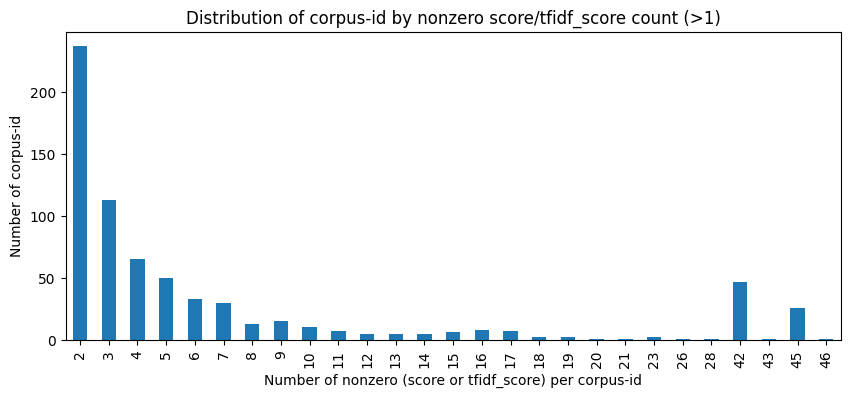

In [32]:
# Print count distribution for all unique corpus-id's with more than 1 nonzero score or tfidf_score
counts = merged_df.groupby('corpus-id').apply(
    lambda g: ((g['score'] > 0) | (g['tfidf_score'] > 0)).sum()
)
filtered_counts = counts[counts > 1]
# print(filtered_counts.value_counts())
# Visualize the count distribution as a bar plot
filtered_counts.value_counts().sort_index().plot(kind='bar', figsize=(10,4))
plt.xlabel('Number of nonzero (score or tfidf_score) per corpus-id')
plt.ylabel('Number of corpus-id')
plt.title('Distribution of corpus-id by nonzero score/tfidf_score count (>1)')
plt.show()

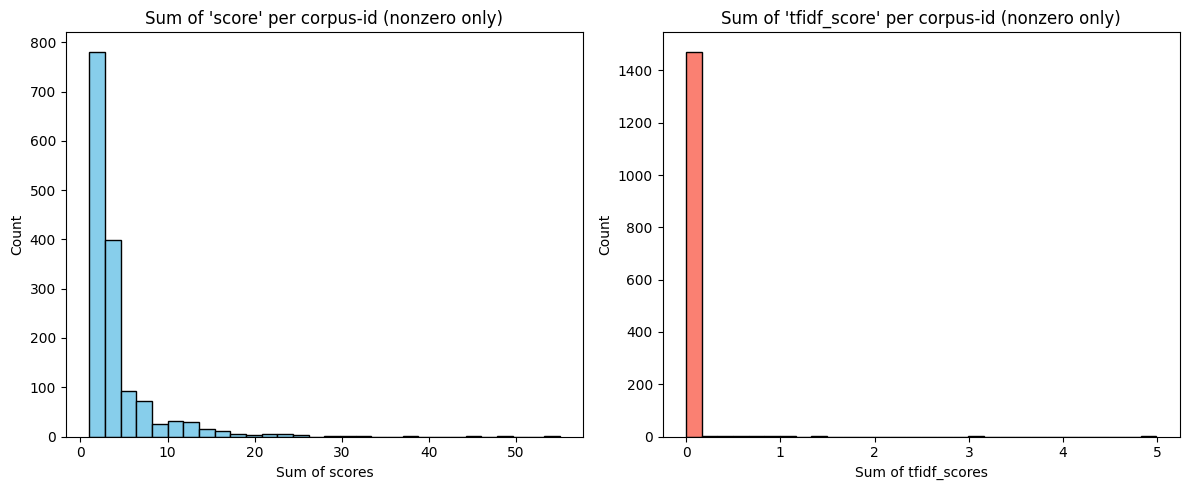

In [33]:
# Filter to corpus-id's with at least one nonzero score
nonzero_corpus_ids = merged_df[merged_df['score'] > 0]['corpus-id'].unique()

# Group by corpus-id and sum scores and tfidf_scores
score_sums = merged_df[merged_df['corpus-id'].isin(nonzero_corpus_ids)].groupby('corpus-id')['score'].sum()
tfidf_sums = merged_df[merged_df['corpus-id'].isin(nonzero_corpus_ids)].groupby('corpus-id')['tfidf_score'].sum()

# Plot distributions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(score_sums, bins=30, color='skyblue', edgecolor='black')
plt.title("Sum of 'score' per corpus-id (nonzero only)")
plt.xlabel("Sum of scores")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(tfidf_sums, bins=30, color='salmon', edgecolor='black')
plt.title("Sum of 'tfidf_score' per corpus-id (nonzero only)")
plt.xlabel("Sum of tfidf_scores")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [34]:
# Checking the queries in the query-id column
for q in merged_df['query-id'].unique():
    print(q)

"as is" clause with carveouts
Cap on liability without carveouts
Clause that requires notice to terminate auto-renew
Covenant Not To Sue
Exclusivity bound by time and territory
Governing Law excluding UCC or other similar regulatory frameworks
IP infringement exception to cap on liability
Insurance
Most Favored Nation Clause
New York Governing Law
Non-Disparagement
Source Code Escrow
Termination for Convenience
a party's liability for fraud, negligence, personal injury or tort subject to a cap
buyer-favorable indemnification clauses
cap on liability
cap on liability for indirect damages
cap on liability subject to law
compliance with law carveout to cap on liability
confidentiality exceptions to indirect damage waiver
disclaimer of indirect damages
disclaimer of lost profits
disclaimer of strict liability
exclusive remedy for breach of product warranty
first party claim exception to waiver of indirect damages
fraud, gross negligence or willful misconduct exception to cap on liability v

#### Mapping the categories to the queries

In [35]:
query_to_category = {
    # Restrictive Covenants
    "Most Favored Nation Clause": "Restrictive Covenants",
    "Non-compete bound by time and territory": "Restrictive Covenants",
    "Exclusivity bound by time and territory": "Restrictive Covenants",
    "No-Solicit of Customers": "Restrictive Covenants",
    "No-Solicit Of Employees not bound by time or longer than 12 months": "Restrictive Covenants",
    "Non-Disparagement": "Restrictive Covenants",
    "Rofr/Rofo/Rofn": "Restrictive Covenants",
    "Change Of Control": "Restrictive Covenants",
    "Anti-Assignment clause that requires notice only for assignment to affiliates": "Restrictive Covenants",
    "Covenant Not To Sue": "Restrictive Covenants",

    # Term
    "Renewal clause that requires notice to Renew": "Term",
    "Clause that requires notice to terminate auto-renew": "Term",
    "Termination for Convenience": "Term",

    # Governing Law
    "New York Governing Law": "Governing Law",
    "England Governing Law": "Governing Law",
    "Clause with multiple governing laws": "Governing Law",
    "Governing Law excluding UCC or other similar regulatory frameworks": "Governing Law",

    # Liquidated Damages
    "Liquidated Damages": "Liquidated Damages",

    # Third party beneficiary
    "Third Party Beneficiary": "Third party beneficiary",

    # IP ownership/license
    "IP Ownership Assignment or Transfer": "IP ownership/license",
    "Joint IP Ownership": "IP ownership/license",
    "License clause covering affiliates of licensor and/or licensee": "IP ownership/license",
    "Source Code Escrow": "IP ownership/license",

    # Affirmative Covenants
    "Revenue/Profit Sharing": "Affirmative Covenants",
    "Minimum Commitment": "Affirmative Covenants",
    "Audit Rights": "Affirmative Covenants",
    "Insurance": "Affirmative Covenants",

    # Limitation of Liability
    '"as is" clause with carveouts': "Limitation of Liability",
    'unqualified "as is" clause': "Limitation of Liability",
    '"as-is" clause': "Limitation of Liability",
    "cap on liability": "Limitation of Liability",
    "cap on liability for indirect damages": "Limitation of Liability",
    "Cap on liability equals 12 months payment": "Limitation of Liability",
    "Cap on liability without carveouts": "Limitation of Liability",
    "cap on liability subject to law": "Limitation of Liability",
    "compliance with law carveout to cap on liability": "Limitation of Liability",
    "confidentiality exceptions to indirect damage waiver": "Limitation of Liability",
    "confidentiality exceptions to liability cap": "Limitation of Liability",
    "consequential damages waiver": "Limitation of Liability",
    "disclaimer of indirect damages": "Limitation of Liability",
    "disclaimer of lost profits": "Limitation of Liability",
    "disclaimer of punitive damages": "Limitation of Liability",
    "disclaimer of strict liability": "Limitation of Liability",
    "exclusive remedy for breach of product warranty": "Limitation of Liability",
    "first party claim exception to waiver of indirect damages": "Limitation of Liability",
    "fraud, gross negligence or willful misconduct carveout to indirect damage waiver": "Limitation of Liability",
    "fraud, negligence or willful misconduct carveout to liability cap": "Limitation of Liability",
    "incidental damages disclaimer": "Limitation of Liability",
    "indemnification carveout to indirect damage waiver": "Limitation of Liability",
    "indemnification carveout to cap on liability": "Limitation of Liability",
    "indirect damages waiver applies to a party's liability for fraud, negligence or personal injury": "Limitation of Liability",
    "indirect damage waiver clauses that exclude third party IP infringement and fraud, gross negligence or willful misconduct": "Limitation of Liability",
    "indirect damage waiver is subject to law": "Limitation of Liability",
    "liability cap carveouts": "Limitation of Liability",
    "liability cap clauses that exclude third party IP infringement and fraud, gross negligence or willful misconduct": "Limitation of Liability",
    "liability cap is based on purchase price": "Limitation of Liability",
    "mutual indirect damages waiver": "Limitation of Liability",
    "mutual liability cap": "Limitation of Liability",
    "non-reliance clause": "Limitation of Liability",
    "personal or bodily injury exception to cap on liability via indemnification carveout": "Limitation of Liability",
    "personal or bodily injury exception to indirect damage waiver": "Limitation of Liability",
    "personal or bodily injury exception to liability cap": "Limitation of Liability",
    "personal or bodily injury exception to waiver of indirect damages via indemnification carveout": "Limitation of Liability",
    "precedents for insurance coverage influencing limitation of liability": "Limitation of Liability",
    "product replacement, repair or refund as exclusivity remedy": "Limitation of Liability",
    "product warranty around manufacturing and shipping": "Limitation of Liability",
    "product warranty of shelf life": "Limitation of Liability",
    "seller-favorable cap on liability clauses": "Limitation of Liability",
    "seller-favorable waiver of indirect damages clauses": "Limitation of Liability",
    "seller-favorable warranty disclaimer clauses": "Limitation of Liability",
    "two parties having different liability caps and/or carveouts": "Limitation of Liability",
    "unilateral indirect damages waiver": "Limitation of Liability",
    "unilateral liability cap": "Limitation of Liability",
    "warranty disclaimer clause that disclaims implied warranties of merchantability and fitness for a particular purpose": "Limitation of Liability",
    "waiver of implied warranty of title and non-infringement": "Limitation of Liability",
    "warranty disclaimer clause that includes implied warranties": "Limitation of Liability",
    "warranty disclaimer that does not specifically waive title and non-infringement warranties": "Limitation of Liability",
    "customer's right for defective products": "Limitation of Liability",
    "a party's liability for fraud, negligence, personal injury or tort subject to a cap": "Limitation of Liability",

    # Indemnification
    "Indemnity of broad-based claims": "Indemnification",
    "Indemnified party includes affiliates": "Indemnification",
    "Indemnification of first party claims": "Indemnification",
    "first party indemnification of broad-based claims": "Indemnification",
    "first party indemnification of specified claims": "Indemnification",
    "indemnification clause that allows indemnifying party to control defenses": "Indemnification",
    "indemnification clauses that do not include hold harmless": "Indemnification",
    "indemnification clauses that include defending claims": "Indemnification",
    "indemnification clauses that include hold harmless": "Indemnification",
    "indemnification covers indirect claims": "Indemnification",
    "indemnification of broad-based third party claims": "Indemnification",
    "indemnification of third party claims": "Indemnification",
    "indemnification of third-party claims based on breach of agreement": "Indemnification",
    "indemnification that covers violation of law": "Indemnification",
    "indemnity or indemnification clause": "Indemnification",
    "mutual indemnification provisions": "Indemnification",
    "seller-favorable indemnification clauses": "Indemnification",
    "buyer-favorable indemnification clauses": "Indemnification",
    "third party IP infringement indemnity": "Indemnification",
    "IP infringement indemnity that covers trademark or copyright": "Indemnification",
    "fraud and/or gross negligence indemnity": "Indemnification",
    "unilateral indemnification clause": "Indemnification",
    "third party IP infringement exception to cap on liability via indemnification carveout": "Indemnification",
    "third party IP infringement exception to indirect damage waiver": "Indemnification",
    "third party claim indemnity of fraud, negligence or willful misconduct": "Indemnification",
    "Third Party claim indemnity limited to use of products in compliance with agreement": "Indemnification",
    "IP infringement exception to cap on liability": "Indemnification",
    "IP infringement exception to indirect damage waiver": "Indemnification",

    #name formatting adjusted
    "fraud, gross negligence or willful misconduct exception to cap on liability via indemnification carveout": "Limitation of Liability",
    "fraud, gross negligence or willful misconduct exception to waiver of indirect damages via indemnification carveout": "Limitation of Liability",
    "Fix fee liability cap": "Limitation of Liability",
    "buyer-favorable waiver of indirect damages clauses": "Limitation of Liability",
    "buyer-favorable warranty disclaimer clauses": "Limitation of Liability",
    "third party IP infringement exception to cap on liability": "Limitation of Liability",
    "buyer-favorable cap on liability clauses": "Limitation of Liability",

}


In [36]:
# Add the new column to merged_df with the updated query-id mapping
merged_df['category'] = merged_df['query-id'].map(query_to_category)

# Check unmapped entries
unmatched = merged_df[merged_df['category'].isna()]
if not unmatched.empty:
    print("Unmatched query-id values:")
    print(unmatched['query-id'].unique())

In [37]:
# Show distribution of "category" values with non-0 "score"
nonzero_scores = merged_df[merged_df['score'] > 0]
category_counts = nonzero_scores['category'].value_counts()
print(category_counts)

category
Limitation of Liability    1786
Indemnification             859
Restrictive Covenants       318
Affirmative Covenants       128
IP ownership/license        127
Governing Law               113
Term                         98
Third party beneficiary      31
Liquidated Damages           31
Name: count, dtype: int64


In [38]:
print("Categories:", merged_df['category'].nunique(), "\nEmpty categories:", merged_df['category'].isnull().sum())

Categories: 9 
Empty categories: 0


## 4 downsampling

#### Second LDA

In [39]:
# Create a dictionary and BoW corpus
dictionary = Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# LDA model
lda_model1 = gensim.models.LdaMulticore(bow_corpus, num_topics=9, 
                                       id2word=dictionary, passes=10, 
                                       workers=6, eval_every=1,
                                       random_state=42)

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: D

#### LDA score

In [40]:
# Get topic distributions for all documents
num_topics = lda_model1.num_topics
doc_bows = [dictionary.doc2bow(doc) for doc in processed_corpus]
doc_topic_matrix = np.zeros((len(doc_bows), num_topics))
for i, bow in enumerate(doc_bows):
    for topic_id, prob in lda_model1.get_document_topics(bow, minimum_probability=0):
        doc_topic_matrix[i, topic_id] = prob

# Get topic distributions for all queries
query_texts = merged_df['query-id'].unique()
query_bows = [dictionary.doc2bow(preprocess(q)) for q in query_texts]
query_topic_matrix = np.zeros((len(query_bows), num_topics))
for i, bow in enumerate(query_bows):
    for topic_id, prob in lda_model1.get_document_topics(bow, minimum_probability=0):
        query_topic_matrix[i, topic_id] = prob

# Map query-id and corpus-id to their index
query_id_to_idx = {qid: idx for idx, qid in enumerate(query_texts)}
corpus_id_to_idx = {cid: idx for idx, cid in enumerate(merged_df['corpus-id'].unique())}

# Compute LDA score (cosine similarity) for each row
lda_scores = []
for _, row in merged_df.iterrows():
    q_idx = query_id_to_idx[row['query-id']]
    c_idx = corpus_id_to_idx[row['corpus-id']]
    q_vec = query_topic_matrix[q_idx].reshape(1, -1)
    d_vec = doc_topic_matrix[c_idx].reshape(1, -1)
    score = cosine_similarity(q_vec, d_vec)[0, 0]
    lda_scores.append(score)

merged_df['lda_score'] = lda_scores


# SKIP FROM HERE

In [41]:
# Print the topics
for idx, topic in lda_model1.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.046*"party" + 0.030*"claim" + 0.023*"indemnify" + 0.021*"agreement" + 0.020*"damage" + 0.018*"shall" + 0.017*"arise" + 0.016*"liability" + 0.013*"include" + 0.012*"section"
Topic 1: 0.066*"party" + 0.048*"agreement" + 0.040*"shall" + 0.031*"assign" + 0.029*"right" + 0.027*"consent" + 0.026*"transfer" + 0.026*"write" + 0.017*"prior" + 0.016*"affiliate"
Topic 2: 0.039*"license" + 0.025*"grant" + 0.023*"right" + 0.017*"section" + 0.016*"patent" + 0.016*"shall" + 0.015*"spinco" + 0.015*"product" + 0.014*"group" + 0.014*"exclusive"
Topic 3: 0.035*"shall" + 0.023*"product" + 0.015*"year" + 0.014*"minimum" + 0.013*"purchase" + 0.013*"period" + 0.011*"products" + 0.011*"section" + 0.010*"share" + 0.010*"sales"
Topic 4: 0.044*"license" + 0.029*"agreement" + 0.029*"right" + 0.028*"grant" + 0.026*"term" + 0.025*"products" + 0.024*"exclusive" + 0.017*"licensee" + 0.016*"territory" + 0.013*"subject"
Topic 5: 0.037*"shall" + 0.033*"audit" + 0.024*"party" + 0.021*"record" + 0.018*"reasonab

The results are now much better than before. Despite the fact that legal gergon words are present in multiple categories, it is now possible to start identifying some of the topics.

In [42]:
# Visualization of the results
%matplotlib inline

vis = pyLDAvis.gensim_models.prepare(lda_model1, bow_corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [46]:
import pyLDAvis

categories = merged_df['category'].dropna().unique().tolist()
cat_idx_map = {cat: i for i, cat in enumerate(categories)}

# Each "topic" is a category; each "term" is a word in the dictionary
topic_term_dists = np.zeros((len(categories), len(dictionary)))
for i, cat in enumerate(categories):
    # For each category, count word frequencies in all docs of that category
    idxs = merged_df[merged_df['category'] == cat].index
    for idx in idxs:
        bow = dictionary.doc2bow(processed_corpus[idx])
        for word_id, count in bow:
            topic_term_dists[i, word_id] += count
    # Normalize to probability distribution
    if topic_term_dists[i].sum() > 0:
        topic_term_dists[i] /= topic_term_dists[i].sum()

# Document-topic matrix: 1-hot for the document's category
doc_topic_dists = np.zeros((len(merged_df), len(categories)))
for i, cat in enumerate(merged_df['category']):
    if pd.notnull(cat):
        doc_topic_dists[i, cat_idx_map[cat]] = 1

doc_lengths = [len(doc) for doc in processed_corpus]
term_frequency = np.array([dictionary.cfs[i] for i in range(len(dictionary))])

vis = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=[dictionary[i] for i in range(len(dictionary))],
    term_frequency=term_frequency
)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/home/ucloud/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/ucloud/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/ucloud/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [47]:
# Assign each document its most probable LDA topic
lda_topics = [max(lda_model1.get_document_topics(bow), key=lambda x: x[1])[0] for bow in bow_corpus]

# Add the topic assignments to the DataFrame
merged_df['lda_topic'] = lda_topics

# Create a cross-tabulation of LDA topics vs. lawyer categories
topic_vs_category = pd.crosstab(merged_df['lda_topic'], merged_df['category'])


#### Visualization

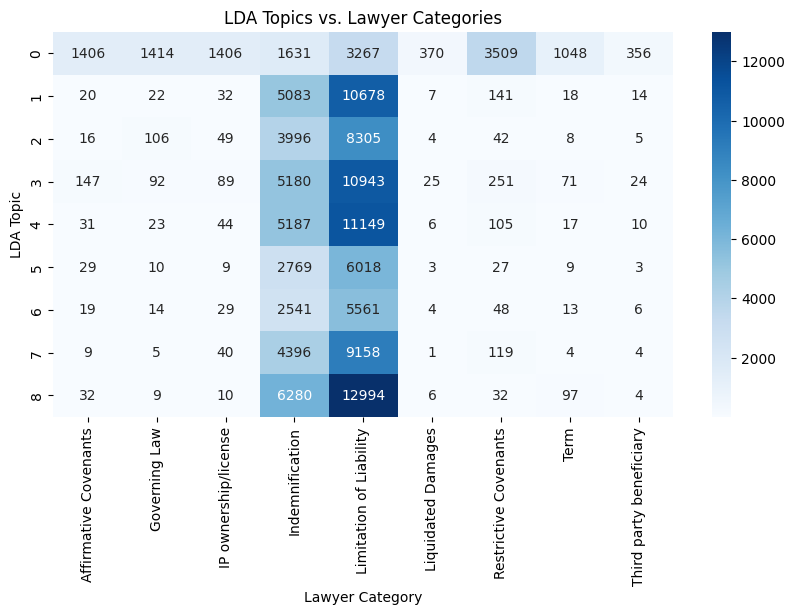

In [48]:
plt.figure(figsize=(10, 5))
sns.heatmap(topic_vs_category, annot=True, fmt='d', cmap='Blues')
plt.ylabel('LDA Topic')
plt.xlabel('Lawyer Category')
plt.title('LDA Topics vs. Lawyer Categories')
plt.show()

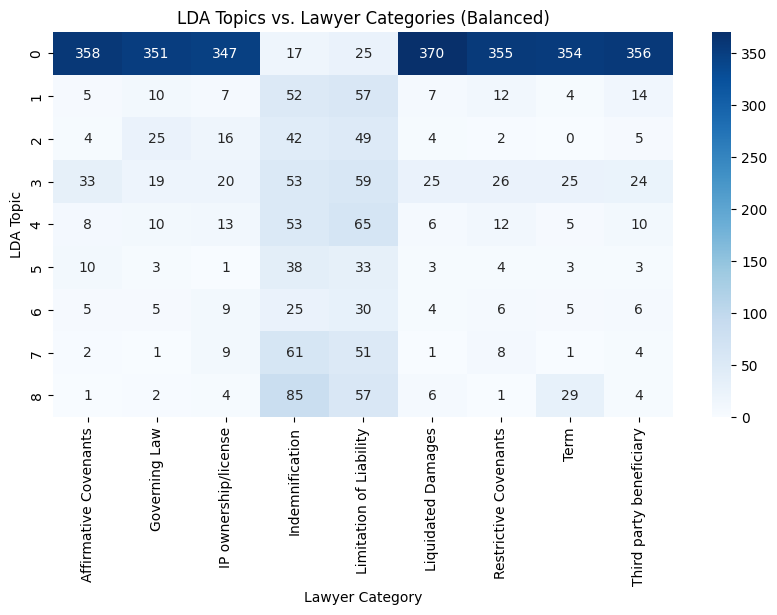

In [49]:
# Balance the categories by downsampling to the size of the smallest category
min_size = merged_df['category'].value_counts().min()
balanced_df = merged_df.groupby('category').sample(n=min_size, random_state=42)

# Cross-tabulation and heatmap
topic_vs_category_balanced = pd.crosstab(balanced_df['lda_topic'], balanced_df['category'])

plt.figure(figsize=(10, 5))
sns.heatmap(topic_vs_category_balanced, annot=True, fmt='d', cmap='Blues')
plt.ylabel('LDA Topic')
plt.xlabel('Lawyer Category')
plt.title('LDA Topics vs. Lawyer Categories (Balanced)')
plt.show()


#### Further preprocess by removing legal jargon
Some common legal words were included in a custom stopwords list and removed during the preprocess. However, removing such words didn't help the lda model to better allign with lawyers grades. As a result we decided to remove this part from the code and only keep this comment to explain the reasoning steps and results, without making the code unnecessarily lenghtly and complex

## 5 NMF

#### NMF

In [50]:
# NMF topic modeling on processed corpus using TF-IDF

# Use the same processed_corpus as for LDA, join tokens for TF-IDF
corpus_strings = [' '.join(doc) for doc in processed_corpus]

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf = tfidf_vectorizer.fit_transform(corpus_strings)

# NMF
num_topics = 9
nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=400)
nmf_W = nmf_model.fit_transform(tfidf)
nmf_H = nmf_model.components_

# Show top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_H):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

# Assign each document its most probable NMF topic
nmf_topics = nmf_W.argmax(axis=1)
merged_df['nmf_topic'] = nmf_topics


Topic 0: license grant licensee right exclusive product licensor royalty products territory
Topic 1: party assign consent agreement transfer write obligations assignment right prior
Topic 2: damage party liability claim indemnify arise breach consequential liable negligence
Topic 3: term agreement date initial terminate renewal effective renew termination shall
Topic 4: insurance liability coverage maintain policy limit general policies insure shall
Topic 5: company distributor consultant products directly solicit agree indirectly period termination
Topic 6: laws state govern construe conflict york principles accordance jurisdiction agreement
Topic 7: audit record reasonable book hours shall business inspect inspection party
Topic 8: warranties imply warranty express fitness merchantability particular disclaim representations purpose


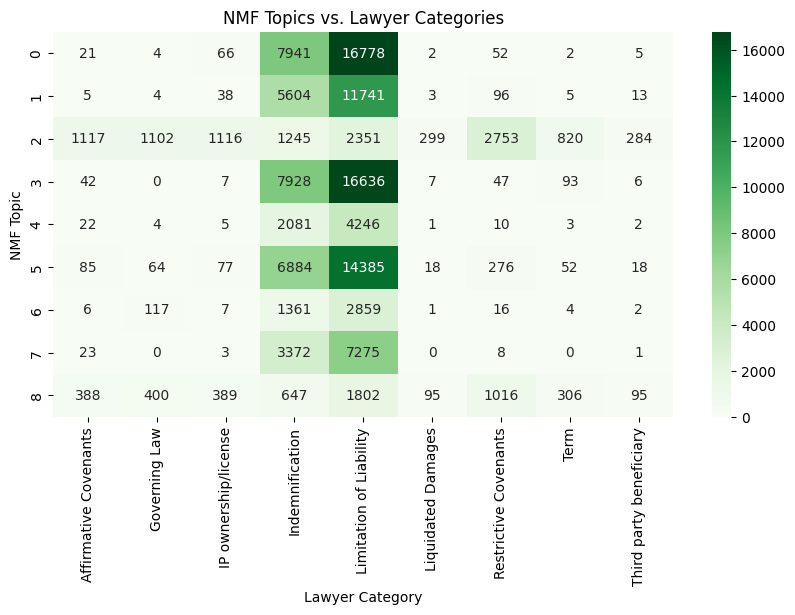

In [51]:
# Compare NMF topics and lawyer categories
topic_vs_category_nmf = pd.crosstab(merged_df['nmf_topic'], merged_df['category'])

# Plot the graph
plt.figure(figsize=(10, 5))
sns.heatmap(topic_vs_category_nmf, annot=True, fmt='d', cmap='Greens')
plt.ylabel('NMF Topic')
plt.xlabel('Lawyer Category')
plt.title('NMF Topics vs. Lawyer Categories')
plt.show()

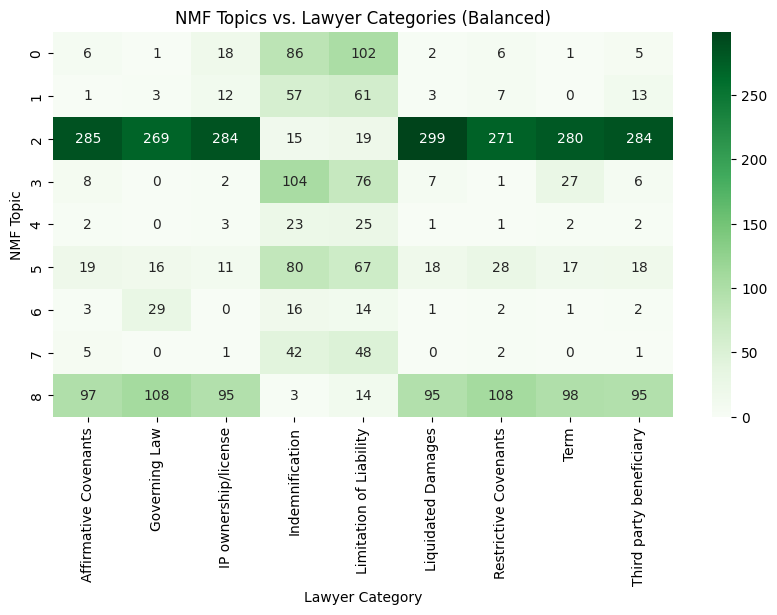

In [52]:
min_size = merged_df['category'].value_counts().min()
balanced_df = merged_df.groupby('category').sample(n=min_size, random_state=42)
topic_vs_category_nmf_balanced = pd.crosstab(balanced_df['nmf_topic'], balanced_df['category'])

plt.figure(figsize=(10, 5))
sns.heatmap(topic_vs_category_nmf_balanced, annot=True, fmt='d', cmap='Greens')
plt.ylabel('NMF Topic')
plt.xlabel('Lawyer Category')
plt.title('NMF Topics vs. Lawyer Categories (Balanced)')
plt.show()

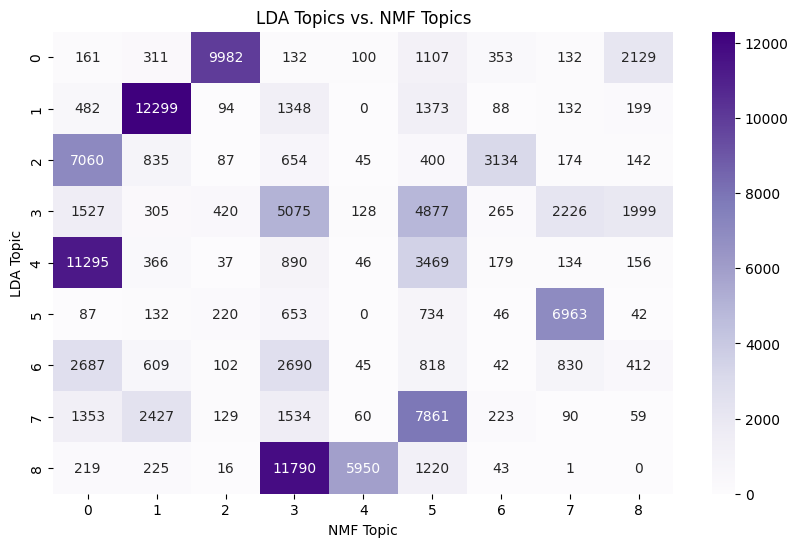

In [53]:
# Compare LDA and NMF topics
lda_nmf_crosstab = pd.crosstab(merged_df['lda_topic'], merged_df['nmf_topic'])

# Plot the graph
plt.figure(figsize=(10, 6))
sns.heatmap(lda_nmf_crosstab, annot=True, fmt='d', cmap='Purples')
plt.xlabel('NMF Topic')
plt.ylabel('LDA Topic')
plt.title('LDA Topics vs. NMF Topics')
plt.show()

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=430) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: D

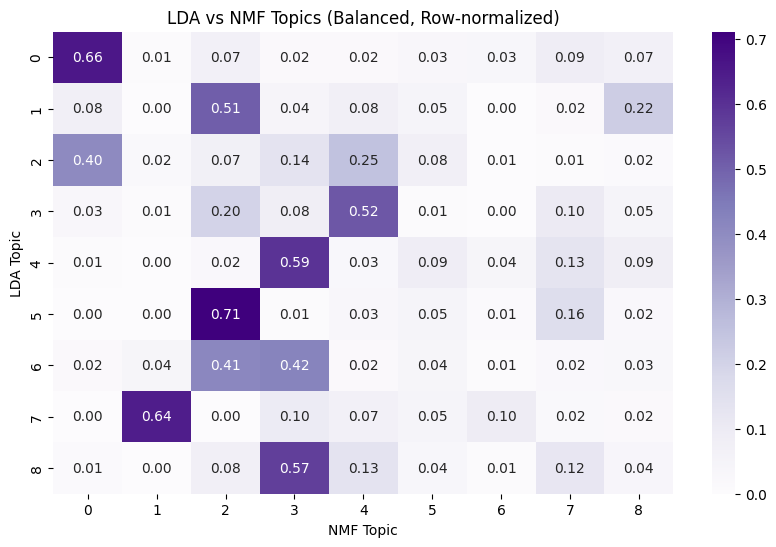

In [54]:
# 1. Preprocess balanced texts
balanced_corpus = balanced_df['text'].apply(preprocess).tolist()
balanced_corpus_strings = [' '.join(doc) for doc in balanced_corpus]

# 2. Refit dictionary and BoW for LDA
balanced_dictionary = Dictionary(balanced_corpus)
balanced_bow = [balanced_dictionary.doc2bow(doc) for doc in balanced_corpus]

# 3. Refit LDA on balanced data
lda_model_bal = gensim.models.LdaMulticore(
    balanced_bow, num_topics=9, id2word=balanced_dictionary, passes=10, workers=6, random_state=42
)
lda_topics_bal = [max(lda_model_bal.get_document_topics(bow), key=lambda x: x[1])[0] for bow in balanced_bow]

# 4. Refit TF-IDF and NMF on balanced data
tfidf_vectorizer_bal = TfidfVectorizer(max_features=2000)
tfidf_bal = tfidf_vectorizer_bal.fit_transform(balanced_corpus_strings)
nmf_model_bal = NMF(n_components=9, random_state=42, max_iter=400)
nmf_W_bal = nmf_model_bal.fit_transform(tfidf_bal)
nmf_topics_bal = nmf_W_bal.argmax(axis=1)

# 5. Assign topics
balanced_df['lda_topic'] = lda_topics_bal
balanced_df['nmf_topic'] = nmf_topics_bal

# 6. Crosstab and plot
lda_nmf_crosstab_bal = pd.crosstab(balanced_df['lda_topic'], balanced_df['nmf_topic'])
# ...existing code...

# Normalize by row (LDA topic)
lda_nmf_crosstab_norm = lda_nmf_crosstab_bal.div(lda_nmf_crosstab_bal.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(lda_nmf_crosstab_norm, annot=True, fmt='.2f', cmap='Purples')
plt.xlabel('NMF Topic')
plt.ylabel('LDA Topic')
plt.title('LDA vs NMF Topics (Balanced, Row-normalized)')
plt.show()

In [55]:
merged_df#.head()

,query-id,corpus-id,score,text,tfidf_score,category,lda_score,lda_topic,nmf_topic
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...,0.0,Limitation of Liability,0.116495,0,8
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...,0.0,Limitation of Liability,0.151278,0,8
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...,0.0,Limitation of Liability,0.178961,4,8
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...,0.0,Limitation of Liability,0.128778,3,8
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...,0.0,Limitation of Liability,0.149152,2,8
...,...,...,...,...,...,...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0,save that nothing in this paragraph 13.2 shall...,0.0,Limitation of Liability,0.040854,1,5
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0,"the Customer is granted a non-exclusive, non-t...",0.0,Limitation of Liability,0.027983,4,0
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0,the Parties may at any time assign or transfer...,0.0,Limitation of Liability,0.024597,1,1
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0,uch fee shall be paid after only the first to ...,0.0,Limitation of Liability,0.029595,3,5


In [56]:
# df exploration
# filter rows in merged_df where category is 'x'
filtered_df = merged_df[merged_df['category'] == 'Restrictive Covenants']

# Show unique values in nmf_topic and their counts
print(filtered_df['nmf_topic'].value_counts())

nmf_topic
2    2753
8    1016
5     276
1      96
0      52
3      47
6      16
4      10
7       8
Name: count, dtype: int64


## 6 word2vec and logreg

##### Compute average word vector

In [57]:
# Construct average word vectors for each document using a pre-trained model
os.environ["GENSIM_DATASETS_SHOW_PROGRESS"] = "False" # Block output prints, otherwise you get warnings for printing too many
# Load the word2vec-google-news-300 model
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [58]:
def avg_feature_vector(words, model, num_features):
    n_words = 0
    feature_vec = np.zeros((num_features,), dtype='float32')
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if n_words > 0:
        feature_vec = feature_vec / n_words
    return feature_vec

# Compute average vectors for all documents in the processed corpus
vectorsize = 300  # word2vec-google-news-300
avg_vectors = np.array([avg_feature_vector(doc, wv, vectorsize) for doc in processed_corpus])

#### Logistic regression model

In [59]:
# Use avg_vectors as features and categories as labels
features = avg_vectors
labels = merged_df['category']

# Split into train and test sets 80-20 
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Fit logistic regression
lr_clf = LogisticRegression(max_iter=1000, class_weight='balanced') #balance classes
lr_clf.fit(train_features, train_labels)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [60]:
# Predict and print classification report
test_predictions = lr_clf.predict(test_features)
print(classification_report(test_labels, test_predictions))

                         precision    recall  f1-score   support

  Affirmative Covenants       0.06      0.06      0.06       342
          Governing Law       0.06      0.13      0.08       339
   IP ownership/license       0.04      0.06      0.05       341
        Indemnification       0.31      0.45      0.37      7413
Limitation of Liability       0.67      0.46      0.55     15615
     Liquidated Damages       0.01      0.06      0.01        85
  Restrictive Covenants       0.23      0.12      0.16       855
                   Term       0.05      0.16      0.08       257
Third party beneficiary       0.01      0.09      0.02        85

               accuracy                           0.42     25332
              macro avg       0.16      0.18      0.15     25332
           weighted avg       0.52      0.42      0.45     25332



# SKIP TO HERE

## 7th BM25

##### BM25 

FORMULA
score(D, Q) = sum over terms t in Q of:
IDF(t) * (f(t, D) * (k1 + 1)) / (f(t, D) + k1 * (1 - b + b * |D| / avgDL))

f(t, D): frequency of term t in document D

|D|: length of document D

avgDL: average document length in the corpus

k1 and b: free parameters (commonly k1=1.5, b=0.75)

IDF(t): inverse document frequency of term t

In [61]:
tokenized_corpus = processed_corpus
bm25 = BM25Okapi(tokenized_corpus)

# Precompute all scores for each unique query
query_texts = merged_df['query-id'].unique()
query_id_to_idx = {qid: idx for idx, qid in enumerate(query_texts)}
corpus_id_to_idx = {cid: idx for idx, cid in enumerate(merged_df['corpus-id'].unique())}
query_to_scores = {}

for qid in query_texts:
    q_idx = query_id_to_idx[qid]
    query = processed_queries[q_idx]
    query_to_scores[qid] = bm25.get_scores(query)

# Assign scores to merged_df
bm25_scores = []
for _, row in merged_df.iterrows():
    qid = row['query-id']
    cid = row['corpus-id']
    doc_idx = corpus_id_to_idx[cid]
    score = query_to_scores[qid][doc_idx]
    bm25_scores.append(score)

merged_df['bm25_score'] = bm25_scores
merged_df

,query-id,corpus-id,score,text,tfidf_score,category,lda_score,lda_topic,nmf_topic,bm25_score
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...,0.0,Limitation of Liability,0.116495,0,8,0.0
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...,0.0,Limitation of Liability,0.151278,0,8,0.0
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...,0.0,Limitation of Liability,0.178961,4,8,0.0
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...,0.0,Limitation of Liability,0.128778,3,8,0.0
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...,0.0,Limitation of Liability,0.149152,2,8,0.0
...,...,...,...,...,...,...,...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0,save that nothing in this paragraph 13.2 shall...,0.0,Limitation of Liability,0.040854,1,5,0.0
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0,"the Customer is granted a non-exclusive, non-t...",0.0,Limitation of Liability,0.027983,4,0,0.0
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0,the Parties may at any time assign or transfer...,0.0,Limitation of Liability,0.024597,1,1,0.0
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0,uch fee shall be paid after only the first to ...,0.0,Limitation of Liability,0.029595,3,5,0.0


#### Evaluation metrics

In [62]:
# NDCG measures the models’ ranking quality by how well they rank
# the most relevant clauses at the top of the search results, focusing on the top results

def compute_ndcg(merged_df, score_col, k_list=[5, 10]):
    results = {}
    for query_id in merged_df['query-id'].unique():
        group = merged_df[merged_df['query-id'] == query_id]
        group = group.sort_values(score_col, ascending=False)
        true_relevance = group['score'].values
        for k in k_list:
            ndcg = ndcg_score([true_relevance], [group[score_col].values], k=k)
            results.setdefault(f'NDCG@{k}', []).append(ndcg)
    for metric, values in results.items():
        print(f"{metric} ({score_col}): {np.mean(values):.4f}")


In [63]:
compute_ndcg(merged_df, score_col="tfidf_score")

NDCG@5 (tfidf_score): 0.0079
NDCG@10 (tfidf_score): 0.0082


In [64]:
compute_ndcg(merged_df, score_col="lda_score")

NDCG@5 (lda_score): 0.0883
NDCG@10 (lda_score): 0.0927


In [65]:
compute_ndcg(merged_df, score_col="bm25_score")

NDCG@5 (bm25_score): 0.0224
NDCG@10 (bm25_score): 0.0180


The results obtained are much lower that the ones obtaines by the authors of the paper. 

The authors in fact only consider scores above 2 stars "Though 1-star clauses
are not individually rated, they are irrelevant ...[]" and when computing the NDCG Score they focus only on the top results.

with this in mind, comparing our results of the entire dataset pairs with theirs is useless and gives much less insights. In fact, as already explained multilple times during the dataset description, the vast majority of datapoint pairs are not linked with eachother. 

The following metrics are much more similar to the ones used by the authors of the paper. The same metrics now are considered by category and exclude zero scores, thus only keeping relevant query-corpus pairs

In [66]:
def compute_ndcg_by_category(merged_df, score_col, k_list=[5, 10]):
    results = {}
    for category in merged_df['category'].dropna().unique():
        group = merged_df[merged_df['category'] == category]
        # Ignore rows with zero true relevance
        group = group[group['score'] > 0]
        if len(group) == 0:
            continue
        group = group.sort_values(score_col, ascending=False)
        true_relevance = group['score'].values
        for k in k_list:
            ndcg = ndcg_score([true_relevance], [group[score_col].values], k=k)
            results.setdefault(f'NDCG@{k}', []).append(ndcg)
    for metric, values in results.items():
        print(f"{metric} ({score_col}): {np.mean(values):.4f}")


In [67]:
compute_ndcg_by_category(merged_df, score_col="tfidf_score")

NDCG@5 (tfidf_score): 0.4681
NDCG@10 (tfidf_score): 0.4880


In [68]:
compute_ndcg_by_category(merged_df, score_col="lda_score")

NDCG@5 (lda_score): 0.5165
NDCG@10 (lda_score): 0.5118


In [69]:
compute_ndcg_by_category(merged_df, score_col="bm25_score")

NDCG@5 (bm25_score): 0.4753
NDCG@10 (bm25_score): 0.4948


The results are very similar to the ones in the paper:

NDCG@5 (bm25_score): 47.5 vs 52.5

NDCG@10 (bm25_score): 49.5 vs 54.

The difference can be the result of preprocessing and a different rigor in excluding pairs

## 8 reranking w/ ms-marco

#### Reranker using pretrained ms-marco LM

In [70]:
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
model.eval()
#model.cpu() # Use CPU, remove comment for Apple M compatibility

def rerank(query, docs):
    pairs = [(query, doc) for doc in docs]
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.cpu() for k, v in inputs.items()} # Force CPU
    with torch.no_grad():
        logits = model(**inputs).logits
        # If logits is 2D, take the correct column (for binary classification)
        if logits.dim() == 2 and logits.shape[1] == 1:
            scores = logits.squeeze(1).cpu().numpy()
        else:
            scores = logits.squeeze().cpu().numpy()
    return scores


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [71]:
# Prepare a new column for reranker scores
merged_df['bm25_reranker_score'] = np.nan

# For each query, rerank only the top 5 BM25 docs
for query_id in tqdm(merged_df['query-id'].unique()):
    group = merged_df[merged_df['query-id'] == query_id]
    top5 = group.sort_values('bm25_score', ascending=False).head(50) #50 or 100 doesn't make any difference
    docs = top5['text'].tolist()
    if len(docs) == 0:
        continue
    scores = rerank(query_id, docs)
    # Assign scores back to the DataFrame
    for idx, score in zip(top5.index, scores):
        merged_df.at[idx, 'bm25_reranker_score'] = score

  0%|          | 0/114 [00:00<?, ?it/s]

100%|██████████| 114/114 [01:25<00:00,  1.34it/s]


In [72]:
merged_df

,query-id,corpus-id,score,text,tfidf_score,category,lda_score,lda_topic,nmf_topic,bm25_score,bm25_reranker_score
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...,0.0,Limitation of Liability,0.116495,0,8,0.0,NaN
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...,0.0,Limitation of Liability,0.151278,0,8,0.0,NaN
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...,0.0,Limitation of Liability,0.178961,4,8,0.0,NaN
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...,0.0,Limitation of Liability,0.128778,3,8,0.0,NaN
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...,0.0,Limitation of Liability,0.149152,2,8,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
126654,"fraud, negligence or willful misconduct carveo...",3b7ac92d08,0,save that nothing in this paragraph 13.2 shall...,0.0,Limitation of Liability,0.040854,1,5,0.0,NaN
126655,"fraud, negligence or willful misconduct carveo...",299bfb02bc,0,"the Customer is granted a non-exclusive, non-t...",0.0,Limitation of Liability,0.027983,4,0,0.0,NaN
126656,"fraud, negligence or willful misconduct carveo...",da17cc633c,0,the Parties may at any time assign or transfer...,0.0,Limitation of Liability,0.024597,1,1,0.0,NaN
126657,"fraud, negligence or willful misconduct carveo...",e41b2de7a7,0,uch fee shall be paid after only the first to ...,0.0,Limitation of Liability,0.029595,3,5,0.0,NaN


In [73]:
# Check results
print("Total rows:", len(merged_df))
print("Rows with bm25_score > 0:", (merged_df['bm25_score'] > 0).sum())
print("Rows with reranker_score not NaN:", merged_df['bm25_reranker_score'].notna().sum())
print("Rows with reranker_score NaN:", merged_df['bm25_reranker_score'].isna().sum())

Total rows: 126659
Rows with bm25_score > 0: 3574
Rows with reranker_score not NaN: 5700
Rows with reranker_score NaN: 120959


compute_ndcg_by_category function doesn't work because of NaN values. A new version is defined just for reranker scores. It drops NaN and skips categories with few valid rows, as the results would be invalid or 1, thus misrepresenting the results

In [74]:
# Modified version wich drops NaN rows and skips categories with few valid rows
def compute_ndcg_by_category1(merged_df, score_col, k_list=[5, 10]):
    results = {}
    # Drop rows with NaN in score_col
    df = merged_df.dropna(subset=[score_col, 'score'])
    for category in df['category'].dropna().unique():
        group = df[df['category'] == category]
        if len(group) < 2:  # skip categories
            print(f"Skipping category '{category}' (only {len(group)} valid rows)")
            continue
        group = group.sort_values(score_col, ascending=False)
        true_relevance = group['score'].values
        pred_scores = group[score_col].values
        for k in k_list:
            if len(group) < k:
                continue
            ndcg = ndcg_score([true_relevance], [pred_scores], k=k)
            results.setdefault(f'NDCG@{k}', []).append(ndcg)
    for metric, values in results.items():
        print(f"{metric} ({score_col}): {np.mean(values):.4f}" if values else f"{metric} ({score_col}): N/A")

In [75]:
compute_ndcg_by_category1(merged_df, score_col="bm25_reranker_score")

NDCG@5 (bm25_reranker_score): 0.3868
NDCG@10 (bm25_reranker_score): 0.3801


In [76]:
# Modified version wich drops NaN rows, skips categories with few valid rows,
# and drops rows with layers score equal to zero
def compute_ndcg_by_category0(merged_df, score_col, k_list=[5, 10]):
    results = {}
    # Drop rows with NaN in score_col and lawyers score equal zero
    df = merged_df.dropna(subset=[score_col, 'score'])
    for category in df['category'].dropna().unique():
        group = df[df['category'] == category]
        group = group[group['score'] > 0]
        if len(group) < 2: # skip categories
            print(f"Skipping category '{category}' (only {len(group)} valid rows)")
            continue
        group = group.sort_values(score_col, ascending=False)
        true_relevance = group['score'].values
        pred_scores = group[score_col].values
        for k in k_list:
            if len(group) < k:
                continue
            ndcg = ndcg_score([true_relevance], [pred_scores], k=k)
            results.setdefault(f'NDCG@{k}', []).append(ndcg)
    for metric, values in results.items():
        print(f"{metric} ({score_col}): {np.mean(values):.4f}" if values else f"{metric} ({score_col}): N/A")

In [77]:
compute_ndcg_by_category0(merged_df, score_col="bm25_reranker_score")

Skipping category 'Governing Law' (only 1 valid rows)
Skipping category 'Affirmative Covenants' (only 1 valid rows)
Skipping category 'IP ownership/license' (only 1 valid rows)
Skipping category 'Third party beneficiary' (only 0 valid rows)
Skipping category 'Liquidated Damages' (only 0 valid rows)
NDCG@5 (bm25_reranker_score): 0.7805
NDCG@10 (bm25_reranker_score): 0.7941


## 9 MiniLM

#### mini-BERT

In [78]:
def light_clean(txt: str) -> str:
    """Minimal edits: normalise whitespace + replace curly quotes/dashes."""
    # collapse whitespace                                            
    txt = re.sub(r'\s+', ' ', txt.strip())
    # convert smart quotes to ASCII forms                         
    txt = txt.translate({
        0x2018:"'", 0x2019:"'", 0x201C:'"', 0x201D:'"', 0x2013:'-', 0x2014:'-'})
    #  normalise section §-refs to SECREF token so that model understands when there was a reference to an actual section instead of getiing lost in the numbers
    txt = re.sub(r'§\s*\d[\d\.]*','SECREF', txt)
    return txt

lc_corpus = [light_clean(text) for text in merged_df['text']]
lc_queries = [light_clean(text) for text in merged_df['query-id']]

In [79]:
# Load a pre-trained BERT model (MiniLM is a well balanced choice)
model = SentenceTransformer('all-MiniLM-L6-v2')
# approx. 8.30 minutes to run on 64 ucloud cpu
#11:30 on Apple M1 16GB

# Prepare text data
corpus_texts = lc_corpus
query_texts = lc_queries

# Compute embeddings
corpus_embeddings_mini = model.encode(corpus_texts, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)
query_embeddings_mini = model.encode(query_texts, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1980 [00:00<?, ?it/s]

Batches:   0%|          | 0/1980 [00:00<?, ?it/s]

In [80]:
bert_scores = []
query_id_to_idx = {qid: idx for idx, qid in enumerate(merged_df['query-id'].unique())}
corpus_id_to_idx = {cid: idx for idx, cid in enumerate(merged_df['corpus-id'].unique())}

for _, row in merged_df.iterrows():
    q_idx = query_id_to_idx[row['query-id']]
    c_idx = corpus_id_to_idx[row['corpus-id']]
    score = util.cos_sim(query_embeddings_mini[q_idx], corpus_embeddings_mini[c_idx]).item()
    bert_scores.append(score)

merged_df['bert_score'] = bert_scores

In [81]:
compute_ndcg_by_category(merged_df, score_col="bert_score")

NDCG@5 (bert_score): 0.4533
NDCG@10 (bert_score): 0.4674


#### Reranker on mini BERT scores

In [82]:
# Prepare a new column for reranker scores
merged_df['bert_reranker_score'] = np.nan

for query_id in tqdm(merged_df['query-id'].unique()):
    group = merged_df[merged_df['query-id'] == query_id]
    top5 = group.sort_values('bert_score', ascending=False).head(50)
    docs = top5['text'].tolist()
    if len(docs) == 0:
        continue
    # Get embeddings for the query and docs
    q_idx = query_id_to_idx[query_id]
    query_emb = query_embeddings_mini[q_idx]
    doc_indices = top5.index.tolist()
    doc_embs = [corpus_embeddings_mini[corpus_id_to_idx[merged_df.loc[idx, 'corpus-id']]] for idx in doc_indices]
    # Compute cosine similarities
    scores = [util.cos_sim(query_emb, doc_emb).item() for doc_emb in doc_embs]
    # Assign scores back to the DataFrame
    for idx, score in zip(doc_indices, scores):
        merged_df.at[idx, 'bert_reranker_score'] = score

  0%|          | 0/114 [00:00<?, ?it/s]

100%|██████████| 114/114 [00:01<00:00, 71.66it/s]


In [83]:
compute_ndcg_by_category0(merged_df, score_col="bert_reranker_score")

NDCG@5 (bert_reranker_score): 0.5966
NDCG@10 (bert_reranker_score): 0.5833


## 10 SBERT

drop duplicates to increase efficiency when computing vectors

In [84]:
query_ids   = merged_df['query-id'].drop_duplicates().tolist()

In [85]:
corpus_ids  = merged_df['corpus-id'].drop_duplicates().tolist()
corpus_text = merged_df.drop_duplicates('corpus-id')['text'].tolist()

In [86]:
lc_corpus_base = [light_clean(text) for text in corpus_text]
lc_queries_base = [light_clean(text) for text in query_ids]

In [87]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# approx. 2 (3) minutes to run
# removing duplicates increase resource and time efficiency 

# Compute embeddings
corpus_embeddings_base = model.encode(lc_corpus_base, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True).astype('float32') 
query_embeddings_base = model.encode(lc_queries_base, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True).astype('float32') 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [88]:
import faiss

index = faiss.IndexFlatIP(corpus_embeddings_base.shape[1])
index.add(corpus_embeddings_base)

K_EVAL = 100
D, I = index.search(query_embeddings_base, K_EVAL)


rank_sbert = {                         # ← list of clause IDs per query
    qid: [corpus_ids[i] for i in row]  # map pointer → id
    for qid, row in zip(query_ids, I)
}

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [89]:
# keep ≥ 3-star as relevant
REL_TH = 3

REL_TH = 3

gold_bin = (merged_df[merged_df['score'] >= REL_TH]
            .groupby('query-id', group_keys=False)['corpus-id']
            .apply(set)
            .to_dict() )

gold_graded = (
    merged_df[merged_df['score'] >= REL_TH]
    .groupby('query-id')
    .apply(lambda g: dict(zip(g['corpus-id'], g['score'])), include_groups=False)
    .to_dict()
)

# make sure *every* query appears, even if its set is empty
gold_bin    = {q: gold_bin.get(q, set())   for q in query_ids}
gold_graded = {q: gold_graded.get(q, {})  for q in query_ids}


In [90]:
def p_at_k(rank, gold, k=5):
    return np.mean([sum(c in gold[q] for c in rank[q][:k]) / k for q in rank])

def recall_at_k(rank, gold, k=100):
    return np.mean([len(set(rank[q][:k]) & gold[q]) / (len(gold[q]) or 1)
                    for q in rank])

def mrr(rank, gold):
    return np.mean([next((1/(i+1) for i,c in enumerate(rank[q])
                          if c in gold[q]), 0) for q in rank])

def ndcg_bin(rank, gold, k=10):          # 3★/4★/5★ all count as 1
    y_true  = [[int(c in gold[q]) for c in rank[q][:k]] for q in rank]
    y_score = [list(range(k,0,-1)) for _ in rank]      # descending rank
    return ndcg_score(y_true, y_score, k=k)


In [91]:
print(f"P@5        = {p_at_k(rank_sbert, gold_bin, 5):.3f}")
print(f"MRR        = {mrr(rank_sbert, gold_bin):.3f}")
print(f"Recall@100 = {recall_at_k(rank_sbert, gold_bin, 100):.3f}")
print(f"nDCGbin@10 = {ndcg_bin(rank_sbert, gold_bin, 10):.3f}")


P@5        = 0.079
MRR        = 0.205
Recall@100 = 0.400
nDCGbin@10 = 0.229


In [92]:
# check
first_q = query_ids[0]
print("QUERY:", first_q)
for rank, cid in enumerate(rank_sbert[first_q][:5], 1):
    snippet = merged_df.loc[merged_df['corpus-id'] == cid, 'text'].iloc[0][:120]
    lab = "✓" if cid in gold_bin[first_q] else "✗"
    print(f"{rank:>2} {lab} {cid}  {snippet}…")


QUERY: "as is" clause with carveouts
 1 ✗ 643ca31ef9  (b) THE MATERIALS PROVIDED TO INSTITUTION BY LBIO ARE PROVIDED BY LBIO ON AN "AS IS" BASIS. LBIO HEREBY DISCLAIMS ANY WA…
 2 ✗ 69070ef83e  Notwithstanding the aforesaid, it is agreed that any manufacturing methods applied by Contractor, which are Contractor's…
 3 ✗ c0e71f7863  Without limiting any of the obligations or liabilities of Contractor, whether under this Agreement or by law, subject to…
 4 ✗ ffffa535e9  The duties and obligations of the Remarketing Agent shall be determined solely by the express provisions of this Agreeme…
 5 ✗ ba040a83df  In the event of termination of this Agreement or a cancellation of a Purchase Order, and/or discontinuance of a Product,…


In [93]:
# turn D into a score dict 
rank_scores = {
    qid: {corpus_ids[i]: float(s) for i, s in zip(row, D_row)}
    for qid, row, D_row in zip(query_ids, I, D)
}

def ndcg_lin(rank_sc, gold_sc, k=10):
    y_true  = [[gold_sc[q].get(c, 0)      for c in list(rank_sc[q])[:k]]
               for q in rank_sc]
    y_score = [[rank_sc[q][c]             for c in list(rank_sc[q])[:k]]
               for q in rank_sc]
    return ndcg_score(y_true, y_score, k=k)

print(f"nDCGgraded@10 = {ndcg_lin(rank_scores, gold_graded, 10):.3f}")


nDCGgraded@10 = 0.227


include the sbert score in merged_df to better compare it with previous models

In [94]:
def get_sbert_score(row):
    qid = row['query-id']
    cid = row['corpus-id']
    return rank_scores.get(qid, {}).get(cid, None)  # None if not present

merged_df['sbert_score'] = merged_df.apply(get_sbert_score, axis=1)

In [95]:
merged_df.head()

,query-id,corpus-id,score,text,tfidf_score,category,lda_score,lda_topic,nmf_topic,bm25_score,bm25_reranker_score,bert_score,bert_reranker_score,sbert_score
0,"""as is"" clause with carveouts",e279fd792f,3,Section 9.3 Disclaimer. EXCEPT AS EXPRESSLY SE...,0.0,Limitation of Liability,0.116495,0,8,0.0,NaN,0.288822,0.288822,NaN
1,"""as is"" clause with carveouts",4f06e1c658,3,12.1 Disclaimer of Warranties. THE WARRANTIES ...,0.0,Limitation of Liability,0.151278,0,8,0.0,NaN,0.052402,NaN,NaN
2,"""as is"" clause with carveouts",adec05476d,1,WARRANTY DISCLAIMER\nTHE LICENSED TECHNOLOGY I...,0.0,Limitation of Liability,0.178961,4,8,0.0,NaN,0.126403,NaN,NaN
3,"""as is"" clause with carveouts",494c10db01,3,Disclaimer of Warranties. UNLESS SPECIFIED OTH...,0.0,Limitation of Liability,0.128778,3,8,0.0,NaN,0.141630,NaN,NaN
4,"""as is"" clause with carveouts",e282637c4e,3,NO WARRANTIES.\nExcept as expressly set forth ...,0.0,Limitation of Liability,0.149152,2,8,0.0,NaN,0.090810,NaN,NaN


In [96]:
compute_ndcg_by_category0(merged_df, score_col="sbert_score")

NDCG@5 (sbert_score): 0.6855
NDCG@10 (sbert_score): 0.6733


#### Reranker on sbert

In [97]:
# Prepare a new column for reranker scores based on sbert_score
merged_df['sbert_reranker_score'] = np.nan

for query_id in tqdm(merged_df['query-id'].unique()):
    group = merged_df[merged_df['query-id'] == query_id]
    top_docs = group.sort_values('sbert_score', ascending=False).head(50)
    docs = top_docs['text'].tolist()
    if len(docs) == 0:
        continue
    # Use SBERT embeddings
    q_idx = query_id_to_idx[query_id]
    query_emb = query_embeddings_base[q_idx]
    doc_indices = top_docs.index.tolist()
    doc_embs = [corpus_embeddings_base[corpus_id_to_idx[merged_df.loc[idx, 'corpus-id']]] for idx in doc_indices]
    # Compute cosine similarities
    scores = [util.cos_sim(query_emb, doc_emb).item() for doc_emb in doc_embs]
    # Assign scores back to the DataFrame
    for idx, score in zip(doc_indices, scores):
        merged_df.at[idx, 'sbert_reranker_score'] = score

  0%|          | 0/114 [00:00<?, ?it/s]

100%|██████████| 114/114 [00:01<00:00, 74.17it/s]


In [98]:
compute_ndcg_by_category0(merged_df, score_col="sbert_reranker_score")

NDCG@5 (sbert_reranker_score): 0.6634
NDCG@10 (sbert_reranker_score): 0.6872


## 11 Legal BERT

In [99]:
model = SentenceTransformer('nlpaueb/legal-bert-base-uncased')
# approx. 1.30 minutes to run

# Compute embeddings
corpus_embeddings_legal = model.encode(lc_corpus_base, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True).astype('float32') 
query_embeddings_legal = model.encode(lc_queries_base, batch_size=64, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True).astype('float32') 

No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [100]:
legal_bert_scores = []
query_id_to_idx = {qid: idx for idx, qid in enumerate(merged_df['query-id'].unique())}
corpus_id_to_idx = {cid: idx for idx, cid in enumerate(merged_df['corpus-id'].unique())}

for _, row in merged_df.iterrows():
    q_idx = query_id_to_idx[row['query-id']]
    c_idx = corpus_id_to_idx[row['corpus-id']]
    score = util.cos_sim(query_embeddings_legal[q_idx], corpus_embeddings_legal[c_idx]).item()
    legal_bert_scores.append(score)

merged_df['legal_bert_score'] = legal_bert_scores

In [101]:
compute_ndcg_by_category0(merged_df, score_col="legal_bert_score")

NDCG@5 (legal_bert_score): 0.4618
NDCG@10 (legal_bert_score): 0.4628


#### Reranker on legal bert

In [102]:
# Prepare a new column for reranker scores based on legal_bert_score
merged_df['legal_bert_reranker_score'] = np.nan

for query_id in tqdm(merged_df['query-id'].unique()):
    group = merged_df[merged_df['query-id'] == query_id]
    top_docs = group.sort_values('legal_bert_score', ascending=False).head(50)
    docs = top_docs['text'].tolist()
    if len(docs) == 0:
        continue
    # Use Legal-BERT embeddings
    q_idx = query_id_to_idx[query_id]
    query_emb = query_embeddings_legal[q_idx]
    doc_indices = top_docs.index.tolist()
    doc_embs = [corpus_embeddings_legal[corpus_id_to_idx[merged_df.loc[idx, 'corpus-id']]] for idx in doc_indices]
    # Compute cosine similarities
    scores = [util.cos_sim(query_emb, doc_emb).item() for doc_emb in doc_embs]
    # Assign scores back to the DataFrame
    for idx, score in zip(doc_indices, scores):
        merged_df.at[idx, 'legal_bert_reranker_score'] = score

100%|██████████| 114/114 [00:01<00:00, 73.02it/s]


In [103]:
compute_ndcg_by_category0(merged_df, score_col="legal_bert_reranker_score")

NDCG@5 (legal_bert_reranker_score): 0.5612
NDCG@10 (legal_bert_reranker_score): 0.5181


## 12 Eval summary

#### Evaluation summary
modify the compute_ndcg_by_category function to include the star precision metrics

In [104]:
def compute_ndcg_and_star_precision0(merged_df, score_col, k_list=[5, 10]):
    results = {}
    # Drop rows with NaN in score_col and 'score'
    df = merged_df.dropna(subset=[score_col, 'score'])
    for category in df['category'].dropna().unique():
        group = df[df['category'] == category]
        group = group[group['score'] > 0]
        if len(group) < 2:
            print(f"Skipping category '{category}' (only {len(group)} valid rows)")
            continue
        group = group.sort_values(score_col, ascending=False)
        true_relevance = group['score'].values
        pred_scores = group[score_col].values

        # NDCG metrics
        for k in k_list:
            if len(group) < k:
                continue
            ndcg = ndcg_score([true_relevance], [pred_scores], k=k)
            results.setdefault(f'NDCG@{k}', []).append(ndcg)

        # Star precision metrics
        top5_scores = true_relevance[:4]
        for star in [4, 3, 2]:
            precision = np.mean(top5_scores >= star)
            results.setdefault(f'{star}-star-precision@5', []).append(precision)

    # Print results
    for metric, values in results.items():
        # If this is a star-precision metric, adjust the star number in the print
        if '-star-precision@' in metric:
            star = int(metric.split('-')[0]) + 1  # add 1 to the star value
            metric_print = metric.replace(f'{star-1}-star', f'{star}-star')
        else:
            metric_print = metric
        print(f"{metric_print} ({score_col}): {np.mean(values):.4f}" if values else f"{metric_print} ({score_col}): N/A")

In [105]:
compute_ndcg_and_star_precision0(merged_df, score_col="bert_reranker_score")

NDCG@5 (bert_reranker_score): 0.5966
NDCG@10 (bert_reranker_score): 0.5833
5-star-precision@5 (bert_reranker_score): 0.0000
4-star-precision@5 (bert_reranker_score): 0.1481
3-star-precision@5 (bert_reranker_score): 0.4352


In [106]:
compute_ndcg_and_star_precision0(merged_df, score_col="sbert_reranker_score")

NDCG@5 (sbert_reranker_score): 0.6634
NDCG@10 (sbert_reranker_score): 0.6872
5-star-precision@5 (sbert_reranker_score): 0.0000
4-star-precision@5 (sbert_reranker_score): 0.4444
3-star-precision@5 (sbert_reranker_score): 0.8056


In [107]:
compute_ndcg_and_star_precision0(merged_df, score_col="bm25_reranker_score")

Skipping category 'Governing Law' (only 1 valid rows)
Skipping category 'Affirmative Covenants' (only 1 valid rows)
Skipping category 'IP ownership/license' (only 1 valid rows)
Skipping category 'Third party beneficiary' (only 0 valid rows)
Skipping category 'Liquidated Damages' (only 0 valid rows)
NDCG@5 (bm25_reranker_score): 0.7805
NDCG@10 (bm25_reranker_score): 0.7941
5-star-precision@5 (bm25_reranker_score): 0.1250
4-star-precision@5 (bm25_reranker_score): 0.3125
3-star-precision@5 (bm25_reranker_score): 0.4375


In [108]:
compute_ndcg_and_star_precision0(merged_df, score_col="legal_bert_reranker_score")

NDCG@5 (legal_bert_reranker_score): 0.5612
NDCG@10 (legal_bert_reranker_score): 0.5181
5-star-precision@5 (legal_bert_reranker_score): 0.0000
4-star-precision@5 (legal_bert_reranker_score): 0.2222
3-star-precision@5 (legal_bert_reranker_score): 0.3611


## 13 Reranker w/ GPT

In [ ]:
import openai
from tqdm import tqdm
import time

openai.api_key = "sk"  # insert the api key

MAX_DOCS_PER_QUERY = 50
MAX_DOC_WORDS = 300
MAX_QUERY_WORDS = 30
MAX_TOKENS_PER_DAY = 2_000_000

# To stay within token limit usage, we truncate corpus text if it is too long
def truncate_words(text, max_words):
    words = text.split()
    return ' '.join(words[:max_words])

# The model used is GTP-4.1-nano
def rerank_gpt41nano_batch(query, docs, model="gpt-4.1-nano"):
    prompt = (
        "Given the following legal query and a list of documents, rate the relevance of each document to the query on a scale from 1 (not relevant) to 5 (highly relevant). "
        "Return a comma-separated list of scores in the same order as the documents.\n\n"
        f"Query: {query}\n\n"
        "Documents:\n"
    )
    for i, doc in enumerate(docs, 1):
        prompt += f"{i}. {doc}\n"
    prompt += "\nRelevance scores (comma-separated, one per document):"

    response = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=4 * len(docs), # output tokens
        temperature=0.0,
    )
    score_text = response.choices[0].message.content.strip() #since multiple documents are given in a signle prompt, multiple scores are given in a signle output
    try: # we need to ensure those scores are considered individually
        scores = [float(s) for s in score_text.split(",")]
    except Exception:
        scores = [float(s) for s in score_text.replace(",", " ").split()]
    return scores

# Prepare a new column for reranker scores
merged_df['sbert_gpt_reranker_score'] = np.nan

# Counters later used to check model output in real-time
total_tokens_used = 0
queries_processed = 0
start_time = time.time() # later used to limit the number of prompts per minute to stay within the limit

for query_id in tqdm(merged_df['query-id'].unique()):
    query_start = time.time()
    group = merged_df[merged_df['query-id'] == query_id]
    top_docs = group.sort_values('sbert_score', ascending=False).head(MAX_DOCS_PER_QUERY)
    docs = [truncate_words(text, MAX_DOC_WORDS) for text in top_docs['text'].tolist()]
    query_text = truncate_words(query_id, MAX_QUERY_WORDS)
    if len(docs) == 0:
        continue

    # No estimated_tokens or stopping condition (to ensure resources weren't wasted we originally limited model freedom)
    for attempt in range(5): # 5 attempts
        try:
            scores = rerank_gpt41nano_batch(query_text, docs)
            for idx, score in zip(top_docs.index, scores):
                merged_df.at[idx, 'sbert_gpt_reranker_score'] = score
            break  # Success, exit retry loop
        except openai.error.RateLimitError as e: # in case we exceed the limit of prompts/minute
            print(f"RateLimitError for query '{query_id}': {e}. Sleeping for 20 seconds...")
            time.sleep(20) # pause the model for 20 seconds
        except Exception as e:
            print(f"Error for query '{query_id}': {e}. Sleeping for 10 seconds...")
            time.sleep(10)
    else: # skip condition
        print(f"Failed to process query '{query_id}' after 5 attempts. Skipping.")
        continue

    queries_processed += 1
    elapsed = time.time() - query_start
    print(f"Query '{query_id}' processed in {elapsed:.2f} seconds.")

total_elapsed = time.time() - start_time
print(f"Processed {queries_processed} queries.")
print(f"Total elapsed time: {total_elapsed/60:.2f} minutes.")

  1%|          | 1/114 [00:02<04:39,  2.48s/it]

Query '"as is" clause with carveouts' processed in 2.48 seconds.


  2%|▏         | 2/114 [00:04<04:01,  2.16s/it]

Query 'Cap on liability without carveouts' processed in 1.93 seconds.


  3%|▎         | 3/114 [00:05<03:29,  1.89s/it]

Query 'Clause that requires notice to terminate auto-renew' processed in 1.56 seconds.


  4%|▎         | 4/114 [00:07<03:29,  1.91s/it]

Query 'Covenant Not To Sue' processed in 1.94 seconds.


  4%|▍         | 5/114 [00:09<03:29,  1.93s/it]

Query 'Exclusivity bound by time and territory' processed in 1.95 seconds.


  5%|▌         | 6/114 [00:11<03:11,  1.78s/it]

Query 'Governing Law excluding UCC or other similar regulatory frameworks' processed in 1.48 seconds.


  6%|▌         | 7/114 [00:13<03:10,  1.78s/it]

Query 'IP infringement exception to cap on liability' processed in 1.80 seconds.


  7%|▋         | 8/114 [00:14<03:02,  1.72s/it]

Query 'Insurance' processed in 1.60 seconds.


  8%|▊         | 9/114 [00:16<02:59,  1.71s/it]

Query 'Most Favored Nation Clause' processed in 1.67 seconds.


  9%|▉         | 10/114 [00:17<02:51,  1.65s/it]

Query 'New York Governing Law' processed in 1.52 seconds.


 10%|▉         | 11/114 [00:19<02:42,  1.57s/it]

Query 'Non-Disparagement' processed in 1.39 seconds.


 11%|█         | 12/114 [00:21<02:42,  1.60s/it]

Query 'Source Code Escrow' processed in 1.65 seconds.


 11%|█▏        | 13/114 [00:22<02:45,  1.64s/it]

Query 'Termination for Convenience' processed in 1.73 seconds.


 12%|█▏        | 14/114 [00:24<02:44,  1.64s/it]

Query 'a party's liability for fraud, negligence, personal injury or tort subject to a cap' processed in 1.65 seconds.


 13%|█▎        | 15/114 [00:25<02:35,  1.57s/it]

Query 'buyer-favorable indemnification clauses' processed in 1.40 seconds.


 14%|█▍        | 16/114 [00:27<02:41,  1.65s/it]

Query 'cap on liability' processed in 1.82 seconds.


 15%|█▍        | 17/114 [00:29<02:38,  1.63s/it]

Query 'cap on liability for indirect damages' processed in 1.59 seconds.


 16%|█▌        | 18/114 [00:31<02:42,  1.69s/it]

Query 'cap on liability subject to law' processed in 1.82 seconds.


 17%|█▋        | 19/114 [00:33<03:02,  1.92s/it]

Query 'compliance with law carveout to cap on liability' processed in 2.46 seconds.


 18%|█▊        | 20/114 [00:35<03:01,  1.94s/it]

Query 'confidentiality exceptions to indirect damage waiver' processed in 1.97 seconds.


 18%|█▊        | 21/114 [00:37<03:07,  2.01s/it]

Query 'disclaimer of indirect damages' processed in 2.20 seconds.


 19%|█▉        | 22/114 [00:39<03:00,  1.96s/it]

Query 'disclaimer of lost profits' processed in 1.84 seconds.


 20%|██        | 23/114 [00:40<02:42,  1.78s/it]

Query 'disclaimer of strict liability' processed in 1.36 seconds.


 21%|██        | 24/114 [00:42<02:42,  1.81s/it]

Query 'exclusive remedy for breach of product warranty' processed in 1.87 seconds.


 22%|██▏       | 25/114 [00:44<02:38,  1.78s/it]

Query 'first party claim exception to waiver of indirect damages' processed in 1.70 seconds.


 23%|██▎       | 26/114 [00:45<02:30,  1.71s/it]

Query 'fraud, gross negligence or willful misconduct exception to cap on liability via indemnification carveout' processed in 1.57 seconds.


 24%|██▎       | 27/114 [00:47<02:36,  1.80s/it]

Query 'fraud, gross negligence or willful misconduct exception to waiver of indirect damages via indemnification carveout' processed in 1.99 seconds.


 25%|██▍       | 28/114 [00:49<02:29,  1.74s/it]

Query 'incidental damages disclaimer' processed in 1.60 seconds.


 25%|██▌       | 29/114 [00:51<02:25,  1.72s/it]

Query 'indemnification carveout to indirect damage waiver' processed in 1.66 seconds.


 26%|██▋       | 30/114 [00:53<02:27,  1.75s/it]

Query 'indemnification clauses that do not include hold harmless' processed in 1.84 seconds.


 27%|██▋       | 31/114 [00:54<02:28,  1.79s/it]

Query 'indemnification covers indirect claims' processed in 1.87 seconds.


 28%|██▊       | 32/114 [00:56<02:13,  1.63s/it]

Query 'indemnification of third party claims' processed in 1.25 seconds.


 29%|██▉       | 33/114 [00:58<02:21,  1.75s/it]

Query 'indemnification of third-party claims based on breach of agreement' processed in 2.03 seconds.


 30%|██▉       | 34/114 [01:00<02:24,  1.80s/it]

Query 'indirect damages waiver applies to a party's liability for fraud, negligence or personal injury' processed in 1.93 seconds.


 31%|███       | 35/114 [01:02<02:28,  1.88s/it]

Query 'liability cap carveouts' processed in 2.06 seconds.


 32%|███▏      | 36/114 [01:03<02:22,  1.82s/it]

Query 'liability cap is based on purchase price' processed in 1.69 seconds.


 32%|███▏      | 37/114 [01:05<02:16,  1.78s/it]

Query 'personal or bodily injury exception to cap on liability via indemnification carveout' processed in 1.67 seconds.


 33%|███▎      | 38/114 [01:07<02:14,  1.77s/it]

Query 'personal or bodily injury exception to indirect damage waiver' processed in 1.76 seconds.


 34%|███▍      | 39/114 [01:09<02:09,  1.73s/it]

Query 'personal or bodily injury exception to waiver of indirect damages via indemnification carveout' processed in 1.64 seconds.


 35%|███▌      | 40/114 [01:10<01:59,  1.61s/it]

Query 'product replacement, repair or refund as exclusivity remedy' processed in 1.34 seconds.


 36%|███▌      | 41/114 [01:12<02:04,  1.71s/it]

Query 'product warranty around manufacturing and shipping' processed in 1.93 seconds.


 37%|███▋      | 42/114 [01:14<02:04,  1.73s/it]

Query 'product warranty of shelf life' processed in 1.79 seconds.


 38%|███▊      | 43/114 [01:15<01:59,  1.69s/it]

Query 'seller-favorable waiver of indirect damages clauses' processed in 1.58 seconds.


 39%|███▊      | 44/114 [01:17<01:53,  1.62s/it]

Query 'seller-favorable warranty disclaimer clauses' processed in 1.44 seconds.


 39%|███▉      | 45/114 [01:18<01:57,  1.70s/it]

Query 'third party IP infringement indemnity' processed in 1.90 seconds.


 40%|████      | 46/114 [01:23<02:56,  2.60s/it]

Query 'third party claim indemnity of fraud, negligence or willful misconduct' processed in 4.70 seconds.


 41%|████      | 47/114 [01:25<02:30,  2.25s/it]

Query 'unqualified "as is" clause' processed in 1.43 seconds.


 42%|████▏     | 48/114 [01:28<02:41,  2.45s/it]

Query 'waiver of implied warranty of title and non-infringement' processed in 2.93 seconds.


 43%|████▎     | 49/114 [01:29<02:22,  2.19s/it]

Query 'warranty disclaimer clause that disclaims implied warranties of merchantability and fitness for a particular purpose' processed in 1.58 seconds.


 44%|████▍     | 50/114 [01:32<02:41,  2.52s/it]

Query 'third party IP infringement exception to cap on liability via indemnification carveout' processed in 3.28 seconds.


 45%|████▍     | 51/114 [01:36<03:07,  2.98s/it]

Query 'indemnification clauses that include hold harmless' processed in 4.06 seconds.


 46%|████▌     | 52/114 [01:40<03:20,  3.23s/it]

Query 'Audit Rights' processed in 3.80 seconds.


 46%|████▋     | 53/114 [01:42<02:48,  2.76s/it]

Query 'Change Of Control' processed in 1.68 seconds.


 47%|████▋     | 54/114 [01:44<02:37,  2.63s/it]

Query 'Clause with multiple governing laws' processed in 2.32 seconds.


 48%|████▊     | 55/114 [01:46<02:18,  2.35s/it]

Query 'England Governing Law' processed in 1.68 seconds.


 49%|████▉     | 56/114 [01:49<02:30,  2.59s/it]

Query 'IP Ownership Assignment or Transfer' processed in 3.16 seconds.


 50%|█████     | 57/114 [01:53<02:43,  2.86s/it]

Query 'Joint IP Ownership' processed in 3.50 seconds.


 51%|█████     | 58/114 [01:56<02:53,  3.10s/it]

Query 'License clause covering affiliates of licensor and/or licensee' processed in 3.64 seconds.


 52%|█████▏    | 59/114 [01:59<02:45,  3.00s/it]

Query 'Minimum Commitment' processed in 2.78 seconds.


 53%|█████▎    | 60/114 [02:02<02:36,  2.90s/it]

Query 'No-Solicit Of Employees not bound by time or longer than 12 months' processed in 2.64 seconds.


 54%|█████▎    | 61/114 [02:04<02:31,  2.86s/it]

Query 'No-Solicit of Customers' processed in 2.79 seconds.


 54%|█████▍    | 62/114 [02:07<02:17,  2.65s/it]

Query 'Renewal clause that requires notice to Renew' processed in 2.15 seconds.


 55%|█████▌    | 63/114 [02:10<02:22,  2.80s/it]

Query 'Revenue/Profit Sharing' processed in 3.13 seconds.


 56%|█████▌    | 64/114 [02:13<02:26,  2.93s/it]

Query 'Rofr/Rofo/Rofn' processed in 3.24 seconds.


 57%|█████▋    | 65/114 [02:16<02:28,  3.02s/it]

Query 'Third Party Beneficiary' processed in 3.24 seconds.


 58%|█████▊    | 66/114 [02:20<02:40,  3.34s/it]

Query 'Liquidated Damages' processed in 4.07 seconds.


 59%|█████▉    | 67/114 [02:22<02:11,  2.80s/it]

Query '"as-is" clause' processed in 1.55 seconds.


 60%|█████▉    | 68/114 [02:26<02:24,  3.13s/it]

Query 'Cap on liability equals 12 months payment' processed in 3.90 seconds.


 61%|██████    | 69/114 [02:29<02:15,  3.01s/it]

Query 'Fix fee liability cap' processed in 2.71 seconds.


 61%|██████▏   | 70/114 [02:32<02:15,  3.07s/it]

Query 'IP infringement exception to indirect damage waiver' processed in 3.22 seconds.


 62%|██████▏   | 71/114 [02:36<02:32,  3.54s/it]

Query 'IP infringement indemnity that covers trademark or copyright' processed in 4.64 seconds.


 63%|██████▎   | 72/114 [02:40<02:31,  3.62s/it]

Query 'Indemnification of first party claims' processed in 3.79 seconds.


 64%|██████▍   | 73/114 [02:44<02:35,  3.80s/it]

Query 'Indemnified party includes affiliates' processed in 4.23 seconds.


 65%|██████▍   | 74/114 [02:47<02:16,  3.40s/it]

Query 'Indemnity of broad-based claims' processed in 2.47 seconds.


 66%|██████▌   | 75/114 [02:51<02:16,  3.49s/it]

Query 'Third Party claim indemnity limited to use of products in compliance with agreement' processed in 3.69 seconds.


 67%|██████▋   | 76/114 [02:53<02:05,  3.29s/it]

Query 'buyer-favorable waiver of indirect damages clauses' processed in 2.83 seconds.


 68%|██████▊   | 77/114 [02:56<01:53,  3.07s/it]

Query 'buyer-favorable warranty disclaimer clauses' processed in 2.55 seconds.


 68%|██████▊   | 78/114 [03:00<01:56,  3.23s/it]

Query 'confidentiality exceptions to liability cap' processed in 3.59 seconds.


 69%|██████▉   | 79/114 [03:02<01:44,  2.99s/it]

Query 'consequential damages waiver' processed in 2.42 seconds.


 70%|███████   | 80/114 [03:05<01:44,  3.07s/it]

Query 'customer's right for defective products' processed in 3.28 seconds.


 71%|███████   | 81/114 [03:08<01:38,  2.98s/it]

Query 'disclaimer of punitive damages' processed in 2.77 seconds.


 72%|███████▏  | 82/114 [03:12<01:48,  3.40s/it]

Query 'fraud and/or gross negligence indemnity' processed in 4.39 seconds.


 73%|███████▎  | 83/114 [03:15<01:42,  3.31s/it]

Query 'fraud, gross negligence or willful misconduct carveout to indirect damage waiver' processed in 3.09 seconds.


 74%|███████▎  | 84/114 [03:20<01:51,  3.71s/it]

Query 'indemnification carveout to cap on liability' processed in 4.66 seconds.


 75%|███████▍  | 85/114 [03:24<01:45,  3.64s/it]

Query 'indemnification clause that allows indemnifying party to control defenses' processed in 3.47 seconds.


 75%|███████▌  | 86/114 [03:27<01:41,  3.63s/it]

Query 'indemnification clauses that include defending claims' processed in 3.61 seconds.


 76%|███████▋  | 87/114 [03:30<01:32,  3.42s/it]

Query 'indemnification of broad-based third party claims' processed in 2.94 seconds.


 77%|███████▋  | 88/114 [03:35<01:03,  2.45s/it]

Query 'indemnification that covers violation of law' processed in 4.71 seconds.
Stopping: daily token limit would be exceeded at query indemnity or indemnification clause
Processed 88 queries, estimated 1993981 tokens used.
Total elapsed time: 3.59 minutes.


In [ ]:
# Save the results in a csv file so that you can later get the results without running the api again
merged_df.to_csv("reranker_progress.csv", index=False)

In [ ]:
# compute_ndcg_and_star_precision0(merged_df, score_col="bm25_gpt_reranker_score")
compute_ndcg_and_star_precision0(merged_df, score_col="sbert_gpt_reranker_score")

NDCG@5 (sbert_gpt_reranker_score): 0.6690
NDCG@10 (sbert_gpt_reranker_score): 0.7029
5-star-precision@5 (sbert_gpt_reranker_score): 0.0278
4-star-precision@5 (sbert_gpt_reranker_score): 0.5278
3-star-precision@5 (sbert_gpt_reranker_score): 0.8333


Excluding reranked bm25 results, which are really good but also biased toward certain categories because of insufficient data, SBERT with GPT reranker obtained the best overall results. Not only the GPT reranker obtained better results than the MS-MARCO reranker, but the quality of the results was also higher, in fact the GPT reranker was the first model to obtain a 5 star precision higher than zero.

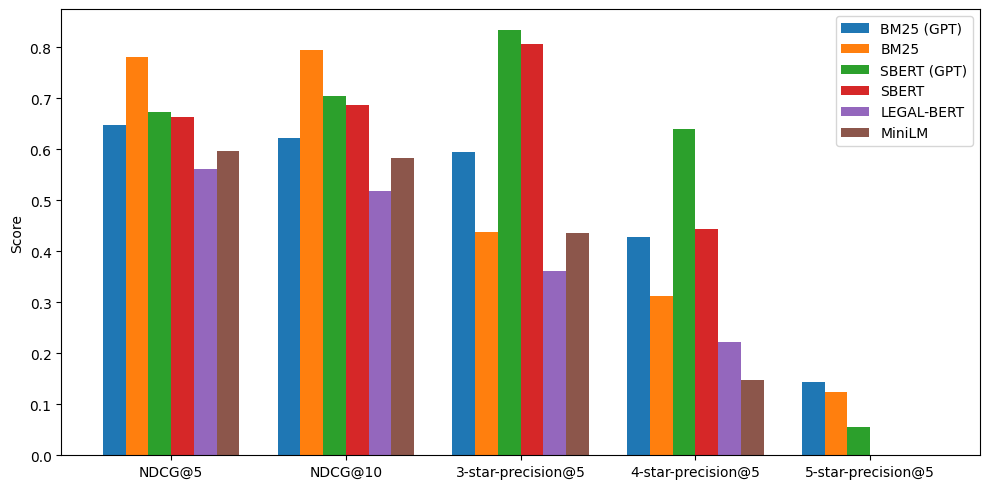

In [111]:
import matplotlib.pyplot as plt
import numpy as np

class MetricsBarPlot:
    def __init__(self, results):
        self.results = results
        self.metrics = list(next(iter(results.values())).keys())
        self.models = list(results.keys())

    def plot(self):
        x = np.arange(len(self.metrics))
        bar_width = 0.13
        offsets = np.linspace(-bar_width*2.5, bar_width*2.5, len(self.models))
        fig, ax = plt.subplots(figsize=(10, 5))
        for i, model in enumerate(self.models):
            vals = [self.results[model][metric] for metric in self.metrics]
            ax.bar(x + offsets[i], vals, width=bar_width, label=model)
        ax.set_xticks(x)
        ax.set_xticklabels(self.metrics)#, rotation=30)
        ax.set_ylim(0, )
        ax.set_ylabel('Score')
        ax.legend()
        plt.tight_layout()
        plt.show()

results_data = {
    "BM25 (GPT)": {
        "NDCG@5": 0.6474,
        "NDCG@10": 0.6226,
        "3-star-precision@5": 0.5952,
        "4-star-precision@5": 0.4286,
        "5-star-precision@5": 0.1429
    },
    "BM25": {
        "NDCG@5": 0.7805,
        "NDCG@10": 0.7941,
        "3-star-precision@5": 0.4375,
        "4-star-precision@5": 0.3125,
        "5-star-precision@5": 0.1250
    },
    "SBERT (GPT)": {
        "NDCG@5": 0.6736,
        "NDCG@10": 0.7050,
        "3-star-precision@5": 0.8333,
        "4-star-precision@5": 0.6389,
        "5-star-precision@5": 0.0556
    },
    "SBERT": {
        "NDCG@5": 0.6634,
        "NDCG@10": 0.6872,
        "3-star-precision@5": 0.8056,
        "4-star-precision@5": 0.4444,
        "5-star-precision@5": 0.0000
    },
    "LEGAL-BERT": {
        "NDCG@5": 0.5612,
        "NDCG@10": 0.5181,
        "3-star-precision@5": 0.3611,
        "4-star-precision@5": 0.2222,
        "5-star-precision@5": 0.0000
    },
    "MiniLM": {
        "NDCG@5": 0.5966,
        "NDCG@10": 0.5833,
        "3-star-precision@5": 0.4352,
        "4-star-precision@5": 0.1481,
        "5-star-precision@5": 0.0000
    },
}

MetricsBarPlot(results_data).plot()